In [1]:
# Cell 1: Imports
# Basic OS, date/time, and numerical libraries
import os
from datetime import datetime
import numpy as np

# Libraries for data handling and scientific computing
import xarray as xr
import dask.array as da # For handling large arrays that don't fit in memory

# PyTorch libraries for deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F # For functions like F.pad, F.gelu
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PyTorch Lightning for streamlining training
import lightning.pytorch as pl

# Plotting library
import matplotlib.pyplot as plt

# Pandas for data manipulation (e.g., creating submission CSV)
import pandas as pd


In [2]:
# Cell 2: Configuration
# Main configuration dictionary for the experiment

# NOTE: You MUST change the 'path' in config['data'] to the correct location 
# of your 'processed_data_cse151b_v2_corrupted_ssp245.zarr' file.
config = {
    "data": {
        "path": "processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245", 
        "test_months": 120,  
        "batch_size": 64, # Adjust based on GPU memory for more complex models
        "num_workers": 4,    
    },
    "model_advanced_cnn": { # Configuration specific to AdvancedCNN
        "type": "advanced_cnn",
        "init_features": 64,     # Initial number of features
        "num_blocks_per_stage": [2, 2, 2, 2], # Number of ResNetBlocks per stage
        "channels_per_stage": [64, 128, 256, 512], # Channels for each stage
        "use_se_block": True,    # Whether to use Squeeze-and-Excitation blocks
        "dropout_rate": 0.1,
    },
    "training": {
        "lr": 1e-3, # May need adjustment for deeper models
    },
    "trainer": {
        "max_epochs": 15, # May need more epochs for deeper models        
        "accelerator": "auto",   
        "devices": "auto",       
        "precision": 32, # Consider '16-mixed' for larger models if memory is an issue         
        "deterministic": True,   
        "num_sanity_val_steps": 0,
    },
    "seed": 42, 
}

pl.seed_everything(config["seed"], workers=True) 

if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 7: 
    torch.set_float32_matmul_precision('medium') 
    print("Set torch.set_float32_matmul_precision('medium') for Tensor Core utilization.")


Seed set to 42


Set torch.set_float32_matmul_precision('medium') for Tensor Core utilization.


In [3]:
# Cell 3: Latitude Weights Utility

def get_lat_weights(latitude_values):
    """
    Computes cosine-based area weights for each latitude.
    """
    lat_rad = np.deg2rad(latitude_values) 
    weights = np.cos(lat_rad)             
    return weights / np.mean(weights)     


In [4]:
# Cell 4: Normalizer Class

class Normalizer:
    """
    Handles Z-score normalization for input and output data.
    """
    def __init__(self):
        self.mean_in, self.std_in = None, None   
        self.mean_out, self.std_out = None, None 

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            if self.mean_in is None or self.std_in is None:
                raise ValueError("Input statistics not set in Normalizer.")
            return (data - self.mean_in) / (self.std_in + 1e-8) 
        elif data_type == "output":
            if self.mean_out is None or self.std_out is None:
                raise ValueError("Output statistics not set in Normalizer.")
            return (data - self.mean_out) / (self.std_out + 1e-8)
        else:
            raise ValueError(f"Invalid data_type '{data_type}'. Must be 'input' or 'output'.")

    def inverse_transform_output(self, data):
        if self.mean_out is None or self.std_out is None:
            raise ValueError("Output statistics not set in Normalizer for inverse transform.")
        return data * (self.std_out + 1e-8) + self.mean_out


In [5]:
# Cell 5: Advanced CNN Model Architecture (ResNet-style with Squeeze-and-Excitation)

class SELayer(nn.Module):
    """Squeeze-and-Excitation Layer"""
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # Squeeze: Global Average Pooling
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False), # Excitation: FC layer
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False), # Excitation: FC layer
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c) # Squeeze
        y = self.fc(y).view(b, c, 1, 1) # Excitation
        return x * y.expand_as(x)       # Scale

class ResNetBlock(nn.Module):
    """ResNet-style block with optional Squeeze-and-Excitation."""
    def __init__(self, in_channels, out_channels, stride=1, use_se=True, reduction=16):
        super(ResNetBlock, self).__init__()
        self.use_se = use_se
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        if self.use_se:
            self.se = SELayer(out_channels, reduction)
            
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            # If stride is not 1 or input/output channels differ, use a 1x1 conv for the shortcut
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.use_se:
            out = self.se(out)
            
        out += self.shortcut(identity) # Add shortcut connection
        out = self.relu(out)           # Final ReLU
        return out

class AdvancedCNN(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, 
                 init_features=64, num_blocks_per_stage=None, 
                 channels_per_stage=None, use_se_block=True, dropout_rate=0.1):
        super(AdvancedCNN, self).__init__()

        if num_blocks_per_stage is None:
            num_blocks_per_stage = [2, 2, 2, 2] # Default: 4 stages, 2 blocks each
        if channels_per_stage is None:
            channels_per_stage = [64, 128, 256, 512] # Default channel progression

        assert len(num_blocks_per_stage) == len(channels_per_stage), "num_blocks and channels_per_stage must have the same length"

        self.initial_conv = nn.Sequential(
            nn.Conv2d(n_input_channels, init_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(init_features),
            nn.ReLU(inplace=True)
        )
        
        current_channels = init_features
        stages = []
        for i, num_blocks in enumerate(num_blocks_per_stage):
            stage_channels = channels_per_stage[i]
            # First block in a stage might have a stride if we wanted downsampling,
            # but for this task, we'll keep stride=1 to maintain spatial resolution.
            # If channels change, the ResNetBlock handles it in the shortcut.
            stride = 1 # No downsampling between stages for now
            
            blocks = []
            # First block of the stage handles channel changes and potential stride
            blocks.append(ResNetBlock(current_channels, stage_channels, stride=stride, use_se=use_se_block))
            current_channels = stage_channels # Update current channels for subsequent blocks
            
            # Add remaining blocks in the stage
            for _ in range(1, num_blocks):
                blocks.append(ResNetBlock(current_channels, stage_channels, stride=1, use_se=use_se_block))
            stages.append(nn.Sequential(*blocks))
            
        self.stages = nn.Sequential(*stages)
        
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity()

        # Final output convolution to map to n_output_channels
        # The number of channels from the last stage is current_channels
        self.final_conv = nn.Conv2d(current_channels, n_output_channels, kernel_size=1)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.stages(x)
        x = self.dropout(x)
        x = self.final_conv(x)
        return x

# Example instantiation (will be done in the training cell):
# adv_cnn_model = AdvancedCNN(
#     n_input_channels=5, 
#     n_output_channels=2,
#     init_features=config["model_advanced_cnn"]["init_features"],
#     num_blocks_per_stage=config["model_advanced_cnn"]["num_blocks_per_stage"],
#     channels_per_stage=config["model_advanced_cnn"]["channels_per_stage"],
#     use_se_block=config["model_advanced_cnn"]["use_se_block"],
#     dropout_rate=config["model_advanced_cnn"]["dropout_rate"]
# )
# dummy_input = torch.randn(4, 5, 48, 72)
# output = adv_cnn_model(dummy_input)
# print("AdvancedCNN Output Shape:", output.shape)


In [6]:
# Cell 6: ClimateDataset and ClimateDataModule

class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any():
            raise ValueError("NaNs found in input dataset after converting to tensor.")
        if torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in output dataset after converting to tensor.")
        
        print(f"Dataset created. Input shape: {self.inputs.shape}, Output shape: {self.outputs.shape}")


    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        test_months=120,
        batch_size=32,
        num_workers=0,
        seed=42, 
    ):
        super().__init__()
        self.save_hyperparameters() 
        self.normalizer = Normalizer()

    def prepare_data(self):
        if not os.path.exists(self.hparams.path):
            raise FileNotFoundError(f"Data path not found: {self.hparams.path}. Please check config['data']['path'].")

    def setup(self, stage=None):
        ds = xr.open_zarr(self.hparams.path, consolidated=False, chunks={"time": 24})
        
        rsdt_var_for_template = ds["rsdt"]
        if "member_id" in rsdt_var_for_template.dims:
            spatial_template = rsdt_var_for_template.isel(time=0, ssp=0, member_id=0, drop=True)
        else:
            spatial_template = rsdt_var_for_template.isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp_name):
            input_dask_list, output_dask_list = [], []
            
            for var_name in self.hparams.input_vars:
                da_var = ds[var_name].sel(ssp=ssp_name)
                if "latitude" in da_var.dims: 
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.hparams.target_member_id)
                
                if set(da_var.dims) == {"time"}: 
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask_list.append(da_var.data)
            
            for var_name in self.hparams.output_vars:
                da_out = ds[var_name].sel(ssp=ssp_name, member_id=self.hparams.target_member_id)
                if "latitude" in da_out.dims: 
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask_list.append(da_out.data)

            return da.stack(input_dask_list, axis=1), da.stack(output_dask_list, axis=1)

        train_input_list, train_output_list = [], []
        val_input_ssp370, val_output_ssp370 = None, None

        for ssp in self.hparams.train_ssps:
            x_ssp, y_ssp = load_ssp(ssp)
            if ssp == "ssp370": 
                val_input_ssp370 = x_ssp[-self.hparams.test_months:]
                val_output_ssp370 = y_ssp[-self.hparams.test_months:]
                train_input_list.append(x_ssp[:-self.hparams.test_months])
                train_output_list.append(y_ssp[:-self.hparams.test_months])
            else:
                train_input_list.append(x_ssp)
                train_output_list.append(y_ssp)
        
        train_input_all_ssp = da.concatenate(train_input_list, axis=0)
        train_output_all_ssp = da.concatenate(train_output_list, axis=0)

        input_mean = da.nanmean(train_input_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        input_std = da.nanstd(train_input_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        self.normalizer.set_input_statistics(mean=input_mean, std=input_std)

        output_mean = da.nanmean(train_output_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        output_std = da.nanstd(train_output_all_ssp, axis=(0, 2, 3), keepdims=True).compute()
        self.normalizer.set_output_statistics(mean=output_mean, std=output_std)

        train_input_norm = self.normalizer.normalize(train_input_all_ssp, "input")
        train_output_norm = self.normalizer.normalize(train_output_all_ssp, "output")
        
        val_input_norm = self.normalizer.normalize(val_input_ssp370, "input")
        val_output_norm = self.normalizer.normalize(val_output_ssp370, "output")

        test_input_ssp, test_output_ssp = load_ssp(self.hparams.test_ssp)
        test_input_ssp = test_input_ssp[-self.hparams.test_months:] 
        test_output_ssp = test_output_ssp[-self.hparams.test_months:]
        test_input_norm = self.normalizer.normalize(test_input_ssp, "input")

        if stage == "fit" or stage is None:
            self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
            self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        if stage == "test" or stage is None:
            self.test_dataset = ClimateDataset(test_input_norm, test_output_ssp, output_is_normalized=False)
        
        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

        ds.close()

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.hparams.batch_size, shuffle=True,
                          num_workers=self.hparams.num_workers, pin_memory=torch.cuda.is_available(), persistent_workers=self.hparams.num_workers > 0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.hparams.batch_size, shuffle=False,
                          num_workers=self.hparams.num_workers, pin_memory=torch.cuda.is_available(), persistent_workers=self.hparams.num_workers > 0)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.hparams.batch_size, shuffle=False,
                          num_workers=self.hparams.num_workers, pin_memory=torch.cuda.is_available(), persistent_workers=self.hparams.num_workers > 0)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon


In [7]:
# Cell 7: ClimateEmulationModule (PyTorch Lightning)

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model 
        self.save_hyperparameters(ignore=['model']) 
        
        self.criterion = nn.MSELoss() 
        self.normalizer = None 
        
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        return self.model(x)

    def _get_normalizer_from_datamodule(self):
        if hasattr(self.trainer, 'datamodule') and self.trainer.datamodule is not None and hasattr(self.trainer.datamodule, 'normalizer'):
            return self.trainer.datamodule.normalizer
        else:
            print("Warning: Normalizer not found via self.trainer.datamodule. Attempting fallback initialization.")
            temp_dm = ClimateDataModule(**config["data"]) 
            temp_dm.prepare_data()
            temp_dm.setup(stage="test") 
            return temp_dm.normalizer

    def on_fit_start(self):
        self.normalizer = self._get_normalizer_from_datamodule()

    def on_test_start(self):
        if self.normalizer is None: 
            self.normalizer = self._get_normalizer_from_datamodule()

    def training_step(self, batch, batch_idx):
        x, y_norm = batch 
        y_hat_norm = self(x)   
        loss = self.criterion(y_hat_norm, y_norm)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y_norm = batch
        y_hat_norm = self(x)
        loss = self.criterion(y_hat_norm, y_norm)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()

        y_hat_denorm = self.normalizer.inverse_transform_output(y_hat_norm.detach().cpu().numpy())
        y_denorm = self.normalizer.inverse_transform_output(y_norm.detach().cpu().numpy())
        
        self.val_preds.append(y_hat_denorm)
        self.val_targets.append(y_denorm)
        return loss 

    def on_validation_epoch_end(self):
        if not self.trainer.sanity_checking: 
            if not self.val_preds or not self.val_targets: 
                return

            preds_epoch = np.concatenate(self.val_preds, axis=0)
            trues_epoch = np.concatenate(self.val_targets, axis=0)
            
            if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()
            
            self._evaluate(preds_epoch, trues_epoch, phase="val")
            
            np.save("val_preds.npy", preds_epoch)
            np.save("val_trues.npy", trues_epoch)
            
            self.val_preds.clear() 
            self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y_true_denorm = batch 
        y_hat_norm = self(x)    

        if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()
        
        y_hat_denorm = self.normalizer.inverse_transform_output(y_hat_norm.detach().cpu().numpy())
        
        self.test_preds.append(y_hat_denorm)
        self.test_targets.append(y_true_denorm.detach().cpu().numpy()) 

    def on_test_epoch_end(self):
        if not self.test_preds or not self.test_targets: 
            return

        preds_epoch = np.concatenate(self.test_preds, axis=0)
        trues_epoch = np.concatenate(self.test_targets, axis=0)

        if self.normalizer is None: self.normalizer = self._get_normalizer_from_datamodule()

        self._evaluate(preds_epoch, trues_epoch, phase="test")
        
        model_type_for_filename = config.get("model_advanced_cnn", {}).get("type", "adv_cnn") 
        self._save_submission(preds_epoch, model_type=model_type_for_filename) 
        
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

    def _evaluate(self, preds_np, trues_np, phase="val"):
        if self.trainer.datamodule is None or not hasattr(self.trainer.datamodule, 'get_lat_weights'):
            print("Warning: self.trainer.datamodule not fully available in _evaluate. Using fallback for coords/weights.")
            dm_eval = ClimateDataModule(**config["data"]) 
            dm_eval.prepare_data()
            dm_eval.setup(stage=phase) 
            area_weights = dm_eval.get_lat_weights()
            lat, lon = dm_eval.get_coords()
            output_vars = dm_eval.hparams.output_vars
        else:
            area_weights = self.trainer.datamodule.get_lat_weights()
            lat, lon = self.trainer.datamodule.get_coords()
            output_vars = self.trainer.datamodule.hparams.output_vars

        time_coords = np.arange(preds_np.shape[0])
        metrics_summary = {}

        for i, var_name in enumerate(output_vars):
            p_var = preds_np[:, i] 
            t_var = trues_np[:, i] 
            
            p_xr = xr.DataArray(p_var, dims=["time", "y", "x"], coords={"time": time_coords, "y": lat, "x": lon})
            t_xr = xr.DataArray(t_var, dims=["time", "y", "x"], coords={"time": time_coords, "y": lat, "x": lon})

            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean()).item()
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean()).item()
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean().item()

            print(f"[{phase.upper()}] {var_name}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            
            metrics_summary[f"{phase}/{var_name}/rmse"] = rmse
            metrics_summary[f"{phase}/{var_name}/time_mean_rmse"] = mean_rmse
            metrics_summary[f"{phase}/{var_name}/time_std_mae"] = std_mae
        
        self.log_dict(metrics_summary, logger=True)

    def _save_submission(self, predictions_np, model_type="model"):
        if self.trainer.datamodule is None or not hasattr(self.trainer.datamodule, 'get_coords'):
            print("Warning: self.trainer.datamodule not fully available in _save_submission. Using fallback.")
            dm_submission = ClimateDataModule(**config["data"])
            dm_submission.prepare_data()
            dm_submission.setup(stage="test") 
            lat, lon = dm_submission.get_coords()
            output_vars = dm_submission.hparams.output_vars
        else:
            lat, lon = self.trainer.datamodule.get_coords()
            output_vars = self.trainer.datamodule.hparams.output_vars
            
        time_coords_submission = np.arange(predictions_np.shape[0])

        rows = []
        for t_idx, t_val in enumerate(time_coords_submission):
            for var_idx, var_name in enumerate(output_vars):
                for y_idx, y_val in enumerate(lat):
                    for x_idx, x_val in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var_name}_{y_val:.2f}_{x_val:.2f}"
                        pred_value = predictions_np[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred_value})

        submission_df = pd.DataFrame(rows)
        submission_dir = "submissions"
        os.makedirs(submission_dir, exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filepath = os.path.join(submission_dir, f"kaggle_submission_{model_type}_{timestamp}.csv")
        submission_df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")


In [8]:
# Cell 8: Training and Evaluation Script for AdvancedCNN

# --- Instantiate DataModule ---
datamodule = ClimateDataModule(**config["data"])

# --- Instantiate AdvancedCNN Model ---
n_inputs = len(config["data"]["input_vars"])
n_outputs = len(config["data"]["output_vars"])

# Get AdvancedCNN specific config or use defaults
adv_cnn_config_params = config.get("model_advanced_cnn", {}) 
init_features_adv = adv_cnn_config_params.get("init_features", 64)
num_blocks_adv = adv_cnn_config_params.get("num_blocks_per_stage", [2, 2, 2, 2])
channels_adv = adv_cnn_config_params.get("channels_per_stage", [64, 128, 256, 512])
use_se_adv = adv_cnn_config_params.get("use_se_block", True)
dropout_adv = adv_cnn_config_params.get("dropout_rate", 0.1)


advanced_cnn_model = AdvancedCNN(
    n_input_channels=n_inputs, 
    n_output_channels=n_outputs,
    init_features=init_features_adv,
    num_blocks_per_stage=num_blocks_adv,
    channels_per_stage=channels_adv,
    use_se_block=use_se_adv,
    dropout_rate=dropout_adv
)

# --- Instantiate Lightning Module ---
learning_rate = config["training"]["lr"]
lightning_module_adv_cnn = ClimateEmulationModule(advanced_cnn_model, learning_rate=learning_rate)

# --- Setup Trainer ---
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback_adv_cnn = ModelCheckpoint(
    monitor="val/loss", 
    mode="min",         
    filename="adv_cnn-best-{epoch:02d}-{val/loss:.2f}", 
    save_top_k=1,       
    verbose=True
)

early_stop_callback_adv_cnn = EarlyStopping(
    monitor="val/loss",
    patience=5, 
    verbose=True,
    mode="min"
)

trainer_params_adv_cnn = {**config["trainer"]} 
trainer_params_adv_cnn["callbacks"] = [checkpoint_callback_adv_cnn, early_stop_callback_adv_cnn]
# Optional: Add logger
# from lightning.pytorch.loggers import TensorBoardLogger
# logger_adv_cnn = TensorBoardLogger("tb_logs", name="adv_cnn_climate_emulation")
# trainer_params_adv_cnn["logger"] = logger_adv_cnn

trainer_adv_cnn = pl.Trainer(**trainer_params_adv_cnn)

# --- Train the Model ---
print("Starting AdvancedCNN model training...")
trainer_adv_cnn.fit(lightning_module_adv_cnn, datamodule=datamodule)
print("Training finished.")

# --- Test the Model ---
print("Starting AdvancedCNN model testing using the best checkpoint...")
test_results_adv_cnn = trainer_adv_cnn.test(lightning_module_adv_cnn, datamodule=datamodule, ckpt_path="best") 
print("Testing finished.")
print("AdvancedCNN Test Results:", test_results_adv_cnn)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Starting AdvancedCNN model training...
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | model     | AdvancedCNN | 11.3 M | train
1 | criterion | MSELoss     | 0      | train
--------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.032    Total estimated model params size (MB)
131       Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved. New best score: 0.658
Epoch 0, global step 46: 'val/loss' reached 0.65773 (best 0.65773), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_5/checkpoints/adv_cnn-best-epoch=00-val/loss=0.66.ckpt' as top 1


[VAL] tas: RMSE=10.0417, Time-Mean RMSE=7.6693, Time-Stddev MAE=2.8332
[VAL] pr: RMSE=3.5111, Time-Mean RMSE=2.0455, Time-Stddev MAE=1.8374


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.078 >= min_delta = 0.0. New best score: 0.580
Epoch 1, global step 92: 'val/loss' reached 0.58021 (best 0.58021), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_5/checkpoints/adv_cnn-best-epoch=01-val/loss=0.58.ckpt' as top 1


[VAL] tas: RMSE=8.9343, Time-Mean RMSE=6.3300, Time-Stddev MAE=2.7828
[VAL] pr: RMSE=3.4548, Time-Mean RMSE=1.9316, Time-Stddev MAE=1.6787


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.032 >= min_delta = 0.0. New best score: 0.549
Epoch 2, global step 138: 'val/loss' reached 0.54852 (best 0.54852), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_5/checkpoints/adv_cnn-best-epoch=02-val/loss=0.55.ckpt' as top 1


[VAL] tas: RMSE=7.7430, Time-Mean RMSE=6.0699, Time-Stddev MAE=2.1307
[VAL] pr: RMSE=3.4483, Time-Mean RMSE=1.9588, Time-Stddev MAE=1.6751


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.038 >= min_delta = 0.0. New best score: 0.511
Epoch 3, global step 184: 'val/loss' reached 0.51063 (best 0.51063), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_5/checkpoints/adv_cnn-best-epoch=03-val/loss=0.51.ckpt' as top 1


[VAL] tas: RMSE=6.8485, Time-Mean RMSE=4.7695, Time-Stddev MAE=2.1126
[VAL] pr: RMSE=3.3525, Time-Mean RMSE=1.8000, Time-Stddev MAE=1.6157


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.017 >= min_delta = 0.0. New best score: 0.493
Epoch 4, global step 230: 'val/loss' reached 0.49319 (best 0.49319), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_5/checkpoints/adv_cnn-best-epoch=04-val/loss=0.49.ckpt' as top 1


[VAL] tas: RMSE=6.1424, Time-Mean RMSE=4.1915, Time-Stddev MAE=1.9308
[VAL] pr: RMSE=3.3266, Time-Mean RMSE=1.8308, Time-Stddev MAE=1.5473


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.043 >= min_delta = 0.0. New best score: 0.450
Epoch 5, global step 276: 'val/loss' reached 0.44999 (best 0.44999), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_5/checkpoints/adv_cnn-best-epoch=05-val/loss=0.45.ckpt' as top 1


[VAL] tas: RMSE=5.7650, Time-Mean RMSE=4.2082, Time-Stddev MAE=1.7112
[VAL] pr: RMSE=3.1781, Time-Mean RMSE=1.6369, Time-Stddev MAE=1.5374


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.010 >= min_delta = 0.0. New best score: 0.440
Epoch 6, global step 322: 'val/loss' reached 0.43950 (best 0.43950), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_5/checkpoints/adv_cnn-best-epoch=06-val/loss=0.44.ckpt' as top 1


[VAL] tas: RMSE=5.4566, Time-Mean RMSE=3.8775, Time-Stddev MAE=1.7712
[VAL] pr: RMSE=3.1485, Time-Mean RMSE=1.5943, Time-Stddev MAE=1.3398


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.024 >= min_delta = 0.0. New best score: 0.416
Epoch 7, global step 368: 'val/loss' reached 0.41589 (best 0.41589), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_5/checkpoints/adv_cnn-best-epoch=07-val/loss=0.42.ckpt' as top 1


[VAL] tas: RMSE=5.2539, Time-Mean RMSE=3.7854, Time-Stddev MAE=1.5768
[VAL] pr: RMSE=3.0758, Time-Mean RMSE=1.6227, Time-Stddev MAE=1.3641


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.037 >= min_delta = 0.0. New best score: 0.379
Epoch 8, global step 414: 'val/loss' reached 0.37888 (best 0.37888), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_5/checkpoints/adv_cnn-best-epoch=08-val/loss=0.38.ckpt' as top 1


[VAL] tas: RMSE=4.8177, Time-Mean RMSE=3.4450, Time-Stddev MAE=1.6213
[VAL] pr: RMSE=2.9419, Time-Mean RMSE=1.5311, Time-Stddev MAE=1.3609


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.009 >= min_delta = 0.0. New best score: 0.370
Epoch 9, global step 460: 'val/loss' reached 0.37015 (best 0.37015), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_5/checkpoints/adv_cnn-best-epoch=09-val/loss=0.37.ckpt' as top 1


[VAL] tas: RMSE=4.7566, Time-Mean RMSE=3.4117, Time-Stddev MAE=1.4585
[VAL] pr: RMSE=2.9065, Time-Mean RMSE=1.5111, Time-Stddev MAE=1.2256


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.012 >= min_delta = 0.0. New best score: 0.358
Epoch 10, global step 506: 'val/loss' reached 0.35771 (best 0.35771), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_5/checkpoints/adv_cnn-best-epoch=10-val/loss=0.36.ckpt' as top 1


[VAL] tas: RMSE=4.6677, Time-Mean RMSE=3.3893, Time-Stddev MAE=1.5646
[VAL] pr: RMSE=2.8551, Time-Mean RMSE=1.4381, Time-Stddev MAE=1.2268


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.025 >= min_delta = 0.0. New best score: 0.333
Epoch 11, global step 552: 'val/loss' reached 0.33276 (best 0.33276), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_5/checkpoints/adv_cnn-best-epoch=11-val/loss=0.33.ckpt' as top 1


[VAL] tas: RMSE=4.3615, Time-Mean RMSE=3.2446, Time-Stddev MAE=1.1133
[VAL] pr: RMSE=2.7626, Time-Mean RMSE=1.3384, Time-Stddev MAE=1.1798


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.021 >= min_delta = 0.0. New best score: 0.312
Epoch 12, global step 598: 'val/loss' reached 0.31206 (best 0.31206), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_5/checkpoints/adv_cnn-best-epoch=12-val/loss=0.31.ckpt' as top 1


[VAL] tas: RMSE=4.1550, Time-Mean RMSE=3.2407, Time-Stddev MAE=1.1470
[VAL] pr: RMSE=2.6661, Time-Mean RMSE=1.3041, Time-Stddev MAE=1.1483


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 644: 'val/loss' was not in top 1


[VAL] tas: RMSE=4.2550, Time-Mean RMSE=3.1055, Time-Stddev MAE=1.2227
[VAL] pr: RMSE=2.6935, Time-Mean RMSE=1.1852, Time-Stddev MAE=1.1418


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.025 >= min_delta = 0.0. New best score: 0.287
Epoch 14, global step 690: 'val/loss' reached 0.28680 (best 0.28680), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_5/checkpoints/adv_cnn-best-epoch=14-val/loss=0.29.ckpt' as top 1


[VAL] tas: RMSE=4.1320, Time-Mean RMSE=3.0399, Time-Stddev MAE=1.1624
[VAL] pr: RMSE=2.5523, Time-Mean RMSE=1.0919, Time-Stddev MAE=1.1129


`Trainer.fit` stopped: `max_epochs=15` reached.


Training finished.
Starting AdvancedCNN model testing using the best checkpoint...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_5/checkpoints/adv_cnn-best-epoch=14-val/loss=0.29.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/version_5/checkpoints/adv_cnn-best-epoch=14-val/loss=0.29.ckpt


Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=290.3741, Time-Mean RMSE=290.3340, Time-Stddev MAE=3.8559
[TEST] pr: RMSE=3.5004, Time-Mean RMSE=3.1847, Time-Stddev MAE=1.1027
✅ Submission saved to: submissions/kaggle_submission_advanced_cnn_20250517_044707.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     3.500427484512329     │
│  test/pr/time_mean_rmse   │    3.1846842765808105     │
│   test/pr/time_std_mae    │    1.1026861667633057     │
│       test/tas/rmse       │     290.3741455078125     │
│  test/tas/time_mean_rmse  │       290.333984375       │
│   test/tas/time_std_mae   │    3.8559350967407227     │
└───────────────────────────┴───────────────────────────┘

Testing finished.
AdvancedCNN Test Results: [{'test/tas/rmse': 290.3741455078125, 'test/tas/time_mean_rmse': 290.333984375, 'test/tas/time_std_mae': 3.8559350967407227, 'test/pr/rmse': 3.500427484512329, 'test/pr/time_mean_rmse': 3.1846842765808105, 'test/pr/time_std_mae': 1.1026861667633057}]


In [9]:
# Cell 9: Plotting Utilities (Optional)

def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric_val=None, metric_name="Metric"):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5)) 
    fig.suptitle(title, fontsize=16) 

    common_min = min(true_xr.min().item(), pred_xr.min().item())
    common_max = max(true_xr.max().item(), pred_xr.max().item())

    true_xr.plot(ax=axs[0], cmap=cmap, vmin=common_min, vmax=common_max, add_colorbar=True, cbar_kwargs={'label': true_xr.name or 'Value'})
    axs[0].set_title(f"Ground Truth")

    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=common_min, vmax=common_max, add_colorbar=True, cbar_kwargs={'label': pred_xr.name or 'Value'})
    axs[1].set_title(f"Prediction")

    diff = pred_xr - true_xr
    abs_max_diff = np.max(np.abs(diff.data)) if diff.size > 0 else 0.1 
    
    diff_plot_params = {'cmap': diff_cmap, 'add_colorbar': True, 'cbar_kwargs': {'label': 'Difference'}}
    if abs_max_diff > 0: 
        diff_plot_params['vmin'] = -abs_max_diff
        diff_plot_params['vmax'] = abs_max_diff
        
    diff.plot(ax=axs[2], **diff_plot_params)
    
    title_suffix = ""
    if metric_val is not None:
        title_suffix = f" ({metric_name}: {metric_val:.4f})"
    axs[2].set_title(f"Difference (Pred - Truth){title_suffix}")

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()



--- Visualizing Validation Predictions for AdvancedCNN ---


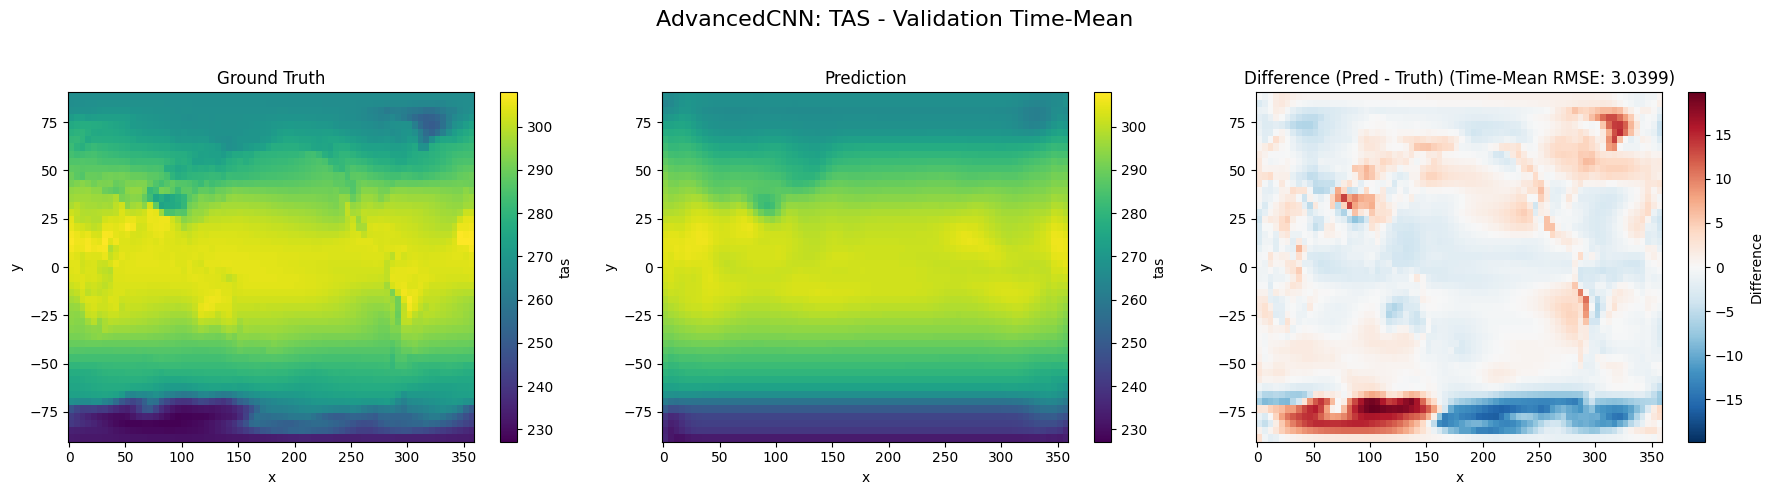

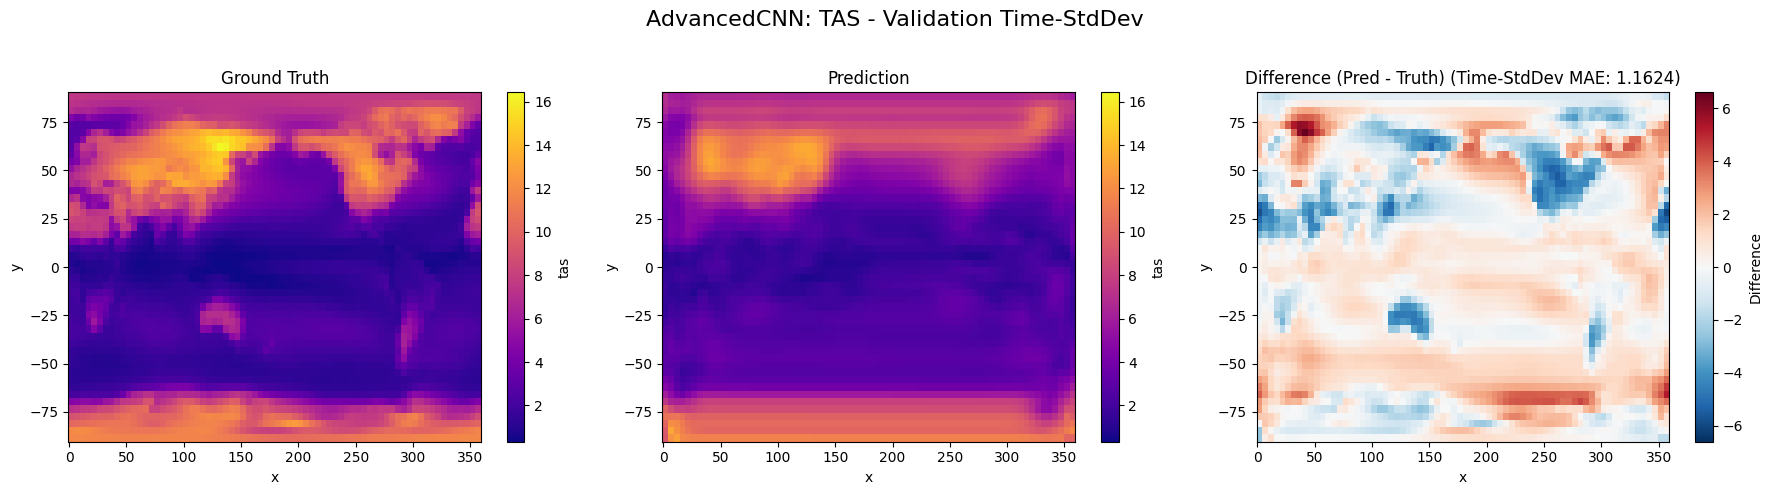

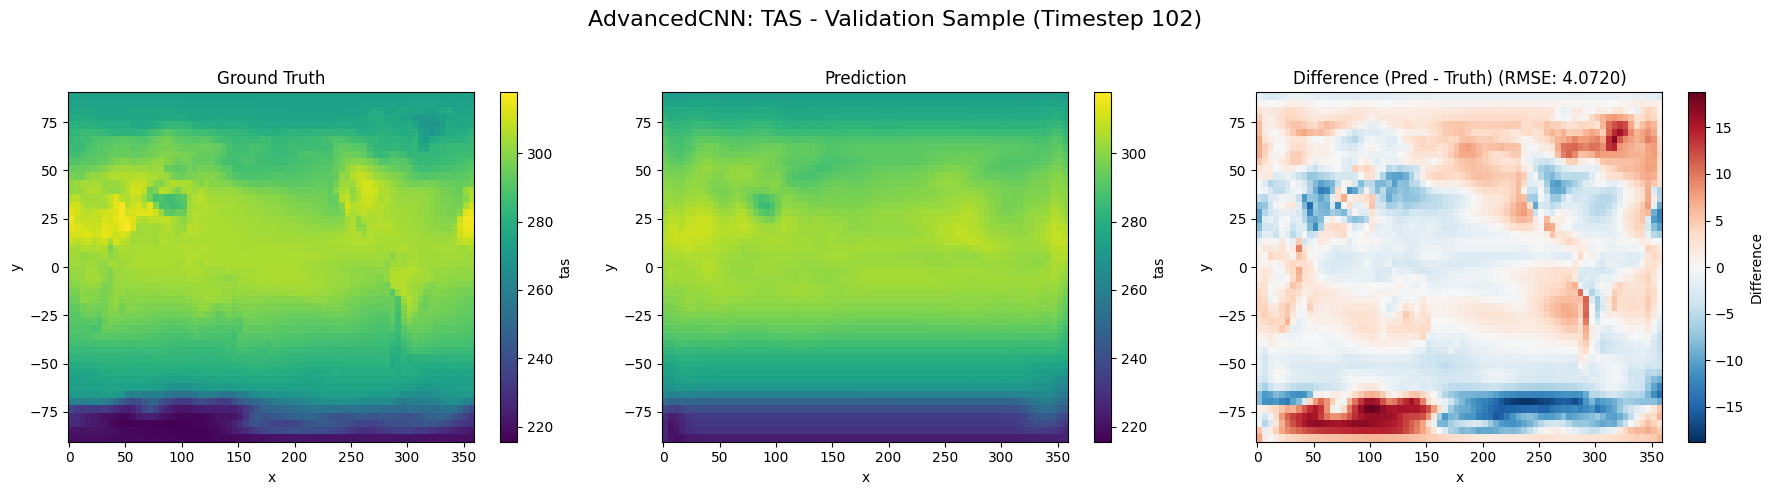

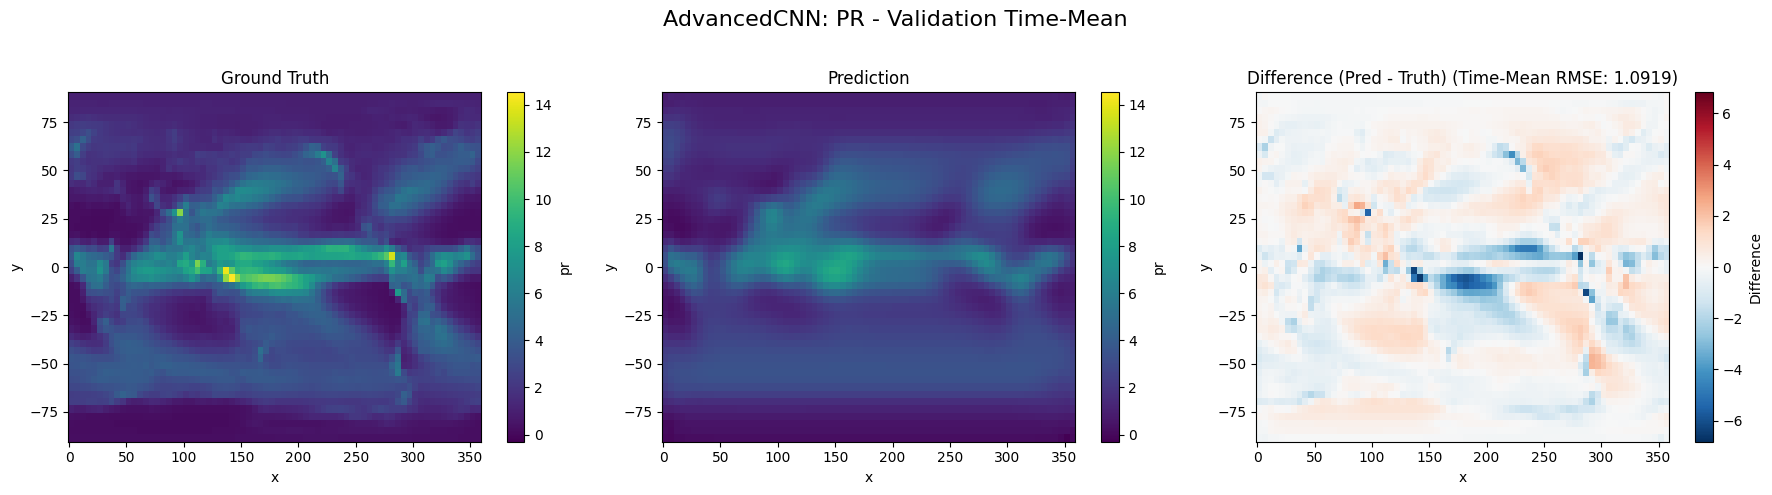

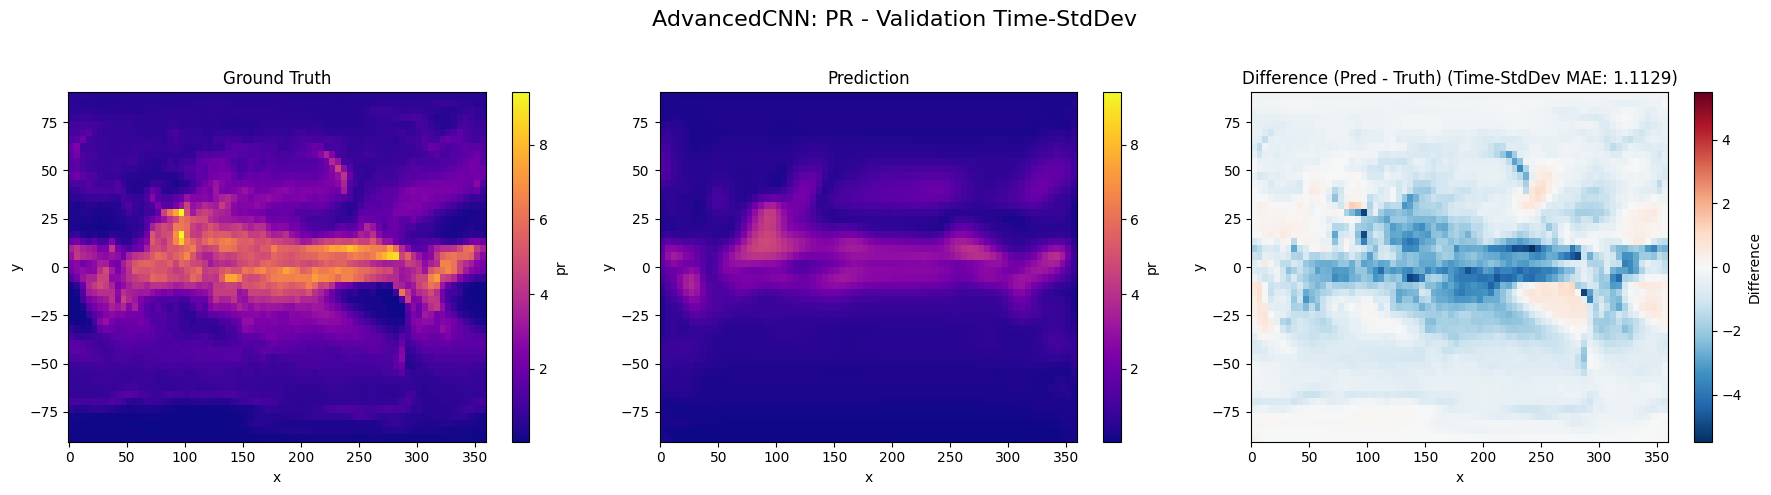

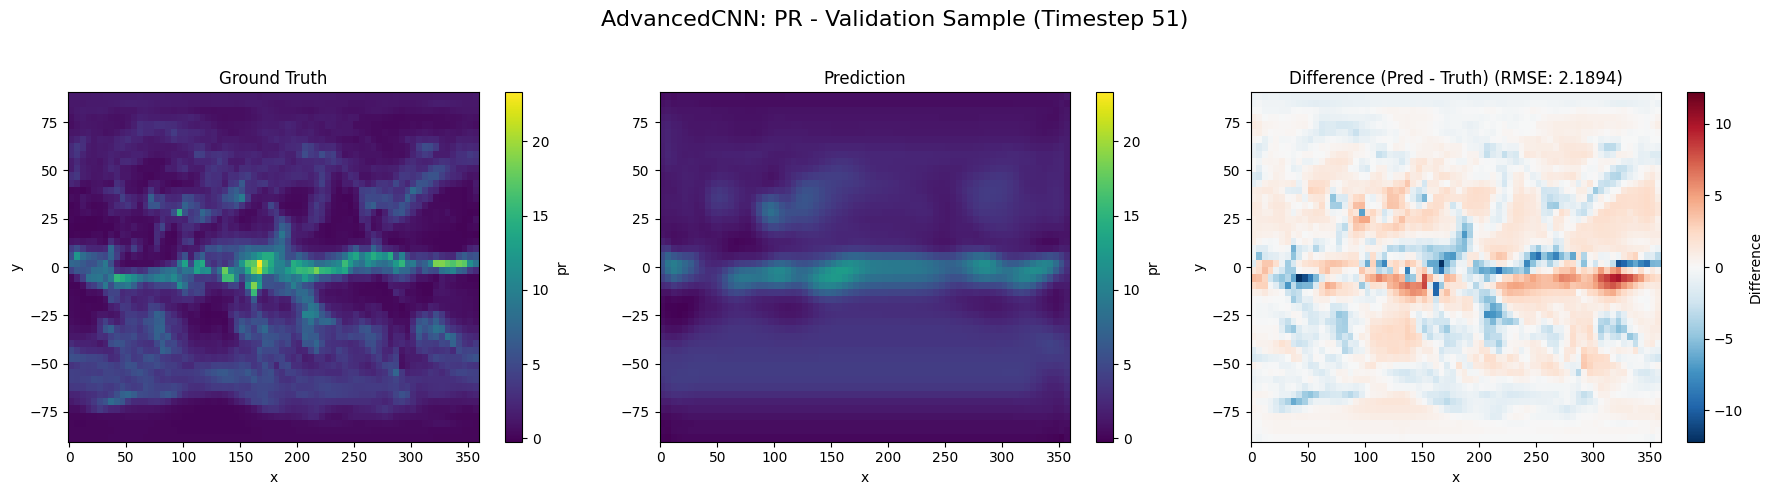

In [10]:
# Cell 10: Visualization Script for AdvancedCNN (Optional)

try:
    # Ensure these files were saved by the AdvancedCNN training run
    val_preds_loaded_adv_cnn = np.load("val_preds.npy") 
    val_trues_loaded_adv_cnn = np.load("val_trues.npy")

    if not hasattr(datamodule, 'lat') or datamodule.lat is None:
        print("Datamodule not fully set up for visualization. Setting it up...")
        datamodule.setup(stage="fit") 

    lat, lon = datamodule.get_coords()
    output_vars = config["data"]["output_vars"] 
    area_weights_vis = datamodule.get_lat_weights() 
    
    time_val_coords = np.arange(val_preds_loaded_adv_cnn.shape[0])

    print(f"\n--- Visualizing Validation Predictions for AdvancedCNN ---")
    for i, var_name in enumerate(output_vars):
        pred_xr_adv_cnn = xr.DataArray(val_preds_loaded_adv_cnn[:, i], dims=["time", "y", "x"], 
                                   coords={"time": time_val_coords, "y": lat, "x": lon}, name=var_name)
        true_xr_adv_cnn = xr.DataArray(val_trues_loaded_adv_cnn[:, i], dims=["time", "y", "x"], 
                                   coords={"time": time_val_coords, "y": lat, "x": lon}, name=var_name)

        pred_mean_adv_cnn = pred_xr_adv_cnn.mean("time")
        true_mean_adv_cnn = true_xr_adv_cnn.mean("time")
        mean_rmse_var_adv_cnn = np.sqrt(((pred_mean_adv_cnn - true_mean_adv_cnn) ** 2).weighted(area_weights_vis).mean()).item()
        plot_comparison(true_mean_adv_cnn, pred_mean_adv_cnn, 
                        f"AdvancedCNN: {var_name.upper()} - Validation Time-Mean",
                        metric_val=mean_rmse_var_adv_cnn, metric_name="Time-Mean RMSE")

        pred_std_adv_cnn = pred_xr_adv_cnn.std("time")
        true_std_adv_cnn = true_xr_adv_cnn.std("time")
        std_mae_var_adv_cnn = np.abs(pred_std_adv_cnn - true_std_adv_cnn).weighted(area_weights_vis).mean().item()
        plot_comparison(true_std_adv_cnn, pred_std_adv_cnn, 
                        f"AdvancedCNN: {var_name.upper()} - Validation Time-StdDev", cmap="plasma",
                        metric_val=std_mae_var_adv_cnn, metric_name="Time-StdDev MAE")

        if len(time_val_coords) > 0:
            t_idx_random_adv_cnn = np.random.randint(0, len(time_val_coords))
            pred_sample_adv_cnn = pred_xr_adv_cnn.isel(time=t_idx_random_adv_cnn)
            true_sample_adv_cnn = true_xr_adv_cnn.isel(time=t_idx_random_adv_cnn)
            sample_rmse_var_adv_cnn = np.sqrt(((pred_sample_adv_cnn - true_sample_adv_cnn) ** 2).weighted(area_weights_vis).mean()).item()
            plot_comparison(true_sample_adv_cnn, pred_sample_adv_cnn, 
                            f"AdvancedCNN: {var_name.upper()} - Validation Sample (Timestep {t_idx_random_adv_cnn})",
                            metric_val=sample_rmse_var_adv_cnn, metric_name="RMSE")
        else:
            print(f"No time steps available in validation predictions for {var_name} to plot a random sample.")

except FileNotFoundError:
    print("val_preds.npy or val_trues.npy not found for AdvancedCNN. "
          "Ensure that the AdvancedCNN training and validation loop (trainer_adv_cnn.fit) has been run successfully, "
          "and the on_validation_epoch_end method in ClimateEmulationModule saved these files.")
except AttributeError as e:
    print(f"AttributeError during AdvancedCNN visualization: {e}. Ensure datamodule is correctly initialized and set up.")
except Exception as e:
    print(f"An error occurred during AdvancedCNN visualization: {e}")



In [11]:
# Cell 11: Advanced CNN Fine-Tuning Loop

from copy import deepcopy
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, TQDMProgressBar
# Ensure previous cells (1-7) with all class definitions (Normalizer, AdvancedCNN, DataModule, LightningModule)
# and the base 'config' dictionary (including a 'model_advanced_cnn' sub-dictionary) are already executed.

print("\n--- Starting AdvancedCNN Fine-Tuning ---")

# Define hyperparameter combinations to try for AdvancedCNN
adv_cnn_hyperparameter_sets = [
    {"adv_cnn_init_features": 32, "adv_cnn_use_se": True,  "adv_cnn_dropout": 0.1, "lr": 1e-3, "optimizer_type": "AdamW", "scheduler_type": "CosineAnnealingLR", "batch_size": 32, "max_epochs_ft": 7},
    {"adv_cnn_init_features": 64, "adv_cnn_use_se": True,  "adv_cnn_dropout": 0.1, "lr": 1e-3, "optimizer_type": "AdamW", "scheduler_type": "CosineAnnealingLR", "batch_size": 32, "max_epochs_ft": 7},
    {"adv_cnn_init_features": 32, "adv_cnn_use_se": False, "adv_cnn_dropout": 0.0, "lr": 5e-4, "optimizer_type": "Adam",  "scheduler_type": None,              "batch_size": 64, "max_epochs_ft": 7},
    {"adv_cnn_init_features": 64, "adv_cnn_use_se": True,  "adv_cnn_dropout": 0.2, "lr": 8e-4, "optimizer_type": "AdamW", "scheduler_type": "CosineAnnealingLR", "batch_size": 32, "max_epochs_ft": 10},
    # Add more combinations. Consider varying num_blocks_per_stage or channels_per_stage if feasible.
]

adv_cnn_fine_tuning_results = []

# Original config for data path and other fixed settings
base_config_trainer_fixed_adv_cnn = {k: v for k, v in config["trainer"].items() if k not in ["max_epochs", "callbacks", "logger", "default_root_dir"]}

for i, params in enumerate(adv_cnn_hyperparameter_sets):
    print(f"\n--- AdvancedCNN Fine-Tuning Run {i+1}/{len(adv_cnn_hyperparameter_sets)} ---")
    print(f"Parameters: {params}")

    # 1. Create a deep copy of the base config and update it
    current_config_adv_cnn = deepcopy(config) 
    current_config_adv_cnn["data"]["batch_size"] = params["batch_size"]
    # Update AdvancedCNN specific model parameters
    current_config_adv_cnn["model_advanced_cnn"]["init_features"] = params["adv_cnn_init_features"]
    current_config_adv_cnn["model_advanced_cnn"]["use_se_block"] = params["adv_cnn_use_se"]
    current_config_adv_cnn["model_advanced_cnn"]["dropout_rate"] = params["adv_cnn_dropout"]
    # num_blocks_per_stage and channels_per_stage will be taken from the main config for this example
    
    # 2. Re-instantiate DataModule
    datamodule_ft_adv_cnn = ClimateDataModule(**current_config_adv_cnn["data"])

    # 3. Re-instantiate AdvancedCNN model
    n_inputs_ft_adv_cnn = len(current_config_adv_cnn["data"]["input_vars"])
    n_outputs_ft_adv_cnn = len(current_config_adv_cnn["data"]["output_vars"])
    
    model_params_from_config = current_config_adv_cnn["model_advanced_cnn"]
    advanced_cnn_model_ft = AdvancedCNN(
        n_input_channels=n_inputs_ft_adv_cnn, 
        n_output_channels=n_outputs_ft_adv_cnn, 
        init_features=model_params_from_config["init_features"],
        num_blocks_per_stage=model_params_from_config.get("num_blocks_per_stage", [2, 2, 2, 2]), # Use default if not in config
        channels_per_stage=model_params_from_config.get("channels_per_stage", [64, 128, 256, 512]), # Use default if not in config
        use_se_block=model_params_from_config["use_se_block"],
        dropout_rate=model_params_from_config["dropout_rate"]
    )

    # 4. Re-instantiate LightningModule
    lightning_module_ft_adv_cnn = ClimateEmulationModule(
        advanced_cnn_model_ft, 
        learning_rate=params["lr"]
    )

    # Override configure_optimizers
    def custom_configure_optimizers_adv_cnn(self_lm):
        if params["optimizer_type"] == "AdamW":
            optimizer = optim.AdamW(self_lm.parameters(), lr=self_lm.hparams.learning_rate, weight_decay=0.01)
        else: 
            optimizer = optim.Adam(self_lm.parameters(), lr=self_lm.hparams.learning_rate)
        
        if params["scheduler_type"] == "CosineAnnealingLR":
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params["max_epochs_ft"], eta_min=1e-6)
            return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "epoch"}}
        return optimizer

    import types
    lightning_module_ft_adv_cnn.configure_optimizers = types.MethodType(custom_configure_optimizers_adv_cnn, lightning_module_ft_adv_cnn)

    # 5. Re-instantiate Trainer
    run_specific_dir_adv_cnn = f"ft_adv_cnn_run_{i+1}"
    
    ft_checkpoint_callback_adv_cnn = ModelCheckpoint(
        monitor="val/loss",
        mode="min",
        dirpath=os.path.join("lightning_logs", run_specific_dir_adv_cnn, "checkpoints"),
        filename="best-adv_cnn-{epoch:02d}-{val/loss:.3f}",
        save_top_k=1,
        verbose=False
    )
    ft_early_stop_callback_adv_cnn = EarlyStopping(
        monitor="val/loss",
        patience=3, 
        verbose=False,
        mode="min"
    )
    ft_progress_bar_adv_cnn = TQDMProgressBar(refresh_rate=10)

    trainer_ft_config_adv_cnn = {
        **base_config_trainer_fixed_adv_cnn,
        "max_epochs": params["max_epochs_ft"],
        "callbacks": [ft_checkpoint_callback_adv_cnn, ft_early_stop_callback_adv_cnn, ft_progress_bar_adv_cnn],
        "logger": pl.loggers.TensorBoardLogger("tb_logs", name=f"adv_cnn_ft_run_{i+1}"),
        "default_root_dir": os.path.join("lightning_logs", run_specific_dir_adv_cnn)
    }
    trainer_ft_adv_cnn = pl.Trainer(**trainer_ft_config_adv_cnn)

    # 6. Run training
    print(f"Fitting AdvancedCNN model for run {i+1} with params: {params}")
    trainer_ft_adv_cnn.fit(lightning_module_ft_adv_cnn, datamodule=datamodule_ft_adv_cnn)
    
    # 7. Evaluate on the validation set using the best checkpoint
    print(f"Evaluating AdvancedCNN model from run {i+1} on validation set...")
    val_results_adv_cnn = trainer_ft_adv_cnn.validate(lightning_module_ft_adv_cnn, datamodule=datamodule_ft_adv_cnn, ckpt_path="best")
    best_val_loss_adv_cnn = val_results_adv_cnn[0].get('val/loss', float('inf'))

    current_run_results_adv_cnn = {
        "params": params,
        "best_val_loss": best_val_loss_adv_cnn,
        "val_metrics": val_results_adv_cnn[0]
    }
    adv_cnn_fine_tuning_results.append(current_run_results_adv_cnn)
    print(f"Run {i+1} (AdvancedCNN) Validation Loss: {best_val_loss_adv_cnn:.4f}")

# 8. Analyze fine-tuning results
print("\n--- AdvancedCNN Fine-Tuning Complete ---")
best_run_adv_cnn = None
best_loss_adv_cnn = float('inf')

for result in adv_cnn_fine_tuning_results:
    print(f"Params: {result['params']}, Best Val Loss: {result['best_val_loss']:.4f}")
    if result['best_val_loss'] < best_loss_adv_cnn:
        best_loss_adv_cnn = result['best_val_loss']
        best_run_adv_cnn = result

if best_run_adv_cnn:
    print(f"\nBest performing AdvancedCNN parameter set:")
    print(f"Params: {best_run_adv_cnn['params']}")
    print(f"Validation Loss: {best_run_adv_cnn['best_val_loss']:.4f}")
    print(f"Full Validation Metrics: {best_run_adv_cnn['val_metrics']}")
else:
    print("No AdvancedCNN fine-tuning runs completed or no results to analyze.")

# After identifying the best hyperparameters, retrain on the full training data 
# for more epochs and evaluate on the held-out test set (ssp245).


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Starting AdvancedCNN Fine-Tuning ---

--- AdvancedCNN Fine-Tuning Run 1/4 ---
Parameters: {'adv_cnn_init_features': 32, 'adv_cnn_use_se': True, 'adv_cnn_dropout': 0.1, 'lr': 0.001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 7}
Fitting AdvancedCNN model for run 1 with params: {'adv_cnn_init_features': 32, 'adv_cnn_use_se': True, 'adv_cnn_dropout': 0.1, 'lr': 0.001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 7}
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | model     | AdvancedCNN | 11.2 M | train
1 | criterion | MSELoss     | 0      | train
--------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.961    Total estimated model params size (MB)
133       Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=9.5989, Time-Mean RMSE=6.1624, Time-Stddev MAE=4.3059
[VAL] pr: RMSE=3.4439, Time-Mean RMSE=1.9643, Time-Stddev MAE=1.7027


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=8.2394, Time-Mean RMSE=6.4214, Time-Stddev MAE=2.3357
[VAL] pr: RMSE=3.4065, Time-Mean RMSE=1.9657, Time-Stddev MAE=1.7034


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.0835, Time-Mean RMSE=4.0567, Time-Stddev MAE=1.7388
[VAL] pr: RMSE=3.2901, Time-Mean RMSE=1.7303, Time-Stddev MAE=1.6139


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.5145, Time-Mean RMSE=4.0415, Time-Stddev MAE=1.7743
[VAL] pr: RMSE=3.1515, Time-Mean RMSE=1.6356, Time-Stddev MAE=1.5475


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.0219, Time-Mean RMSE=3.5947, Time-Stddev MAE=1.4760
[VAL] pr: RMSE=3.1165, Time-Mean RMSE=1.6540, Time-Stddev MAE=1.4881


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.6881, Time-Mean RMSE=3.4999, Time-Stddev MAE=1.4166
[VAL] pr: RMSE=3.0184, Time-Mean RMSE=1.5747, Time-Stddev MAE=1.4296


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5812, Time-Mean RMSE=3.4222, Time-Stddev MAE=1.3479
[VAL] pr: RMSE=2.9850, Time-Mean RMSE=1.5685, Time-Stddev MAE=1.4110


`Trainer.fit` stopped: `max_epochs=7` reached.


Evaluating AdvancedCNN model from run 1 on validation set...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_adv_cnn_run_1/checkpoints/best-adv_cnn-epoch=06-val/loss=0.387.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_adv_cnn_run_1/checkpoints/best-adv_cnn-epoch=06-val/loss=0.387.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5812, Time-Mean RMSE=3.4222, Time-Stddev MAE=1.3479
[VAL] pr: RMSE=2.9850, Time-Mean RMSE=1.5685, Time-Stddev MAE=1.4110


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val/loss          │    0.38660183548927307    │
│        val/pr/rmse        │    2.9850010871887207     │
│   val/pr/time_mean_rmse   │    1.5684609413146973     │
│    val/pr/time_std_mae    │    1.4109922647476196     │
│       val/tas/rmse        │     4.581174850463867     │
│  val/tas/time_mean_rmse   │     3.422238349914551     │
│   val/tas/time_std_mae    │     1.347864031791687     │
└───────────────────────────┴───────────────────────────┘

Run 1 (AdvancedCNN) Validation Loss: 0.3866

--- AdvancedCNN Fine-Tuning Run 2/4 ---
Parameters: {'adv_cnn_init_features': 64, 'adv_cnn_use_se': True, 'adv_cnn_dropout': 0.1, 'lr': 0.001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 7}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Fitting AdvancedCNN model for run 2 with params: {'adv_cnn_init_features': 64, 'adv_cnn_use_se': True, 'adv_cnn_dropout': 0.1, 'lr': 0.001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 7}
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | model     | AdvancedCNN | 11.3 M | train
1 | criterion | MSELoss     | 0      | train
--------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.032    Total estimated model params size (MB)
131       Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=8.9791, Time-Mean RMSE=6.2389, Time-Stddev MAE=2.8925
[VAL] pr: RMSE=3.4626, Time-Mean RMSE=1.9742, Time-Stddev MAE=1.7130


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.7968, Time-Mean RMSE=4.4896, Time-Stddev MAE=2.0158
[VAL] pr: RMSE=3.2850, Time-Mean RMSE=1.6740, Time-Stddev MAE=1.5258


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.9397, Time-Mean RMSE=3.8831, Time-Stddev MAE=1.8121
[VAL] pr: RMSE=3.2676, Time-Mean RMSE=1.7002, Time-Stddev MAE=1.5440


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.3377, Time-Mean RMSE=3.5134, Time-Stddev MAE=1.7888
[VAL] pr: RMSE=3.0975, Time-Mean RMSE=1.5955, Time-Stddev MAE=1.4634


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5340, Time-Mean RMSE=3.3806, Time-Stddev MAE=1.3418
[VAL] pr: RMSE=2.9736, Time-Mean RMSE=1.5524, Time-Stddev MAE=1.3902


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.4321, Time-Mean RMSE=3.3902, Time-Stddev MAE=1.3383
[VAL] pr: RMSE=2.9321, Time-Mean RMSE=1.5284, Time-Stddev MAE=1.3411


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.3434, Time-Mean RMSE=3.3400, Time-Stddev MAE=1.2243
[VAL] pr: RMSE=2.8938, Time-Mean RMSE=1.5237, Time-Stddev MAE=1.3644


`Trainer.fit` stopped: `max_epochs=7` reached.


Evaluating AdvancedCNN model from run 2 on validation set...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_adv_cnn_run_2/checkpoints/best-adv_cnn-epoch=06-val/loss=0.363.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_adv_cnn_run_2/checkpoints/best-adv_cnn-epoch=06-val/loss=0.363.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.3434, Time-Mean RMSE=3.3400, Time-Stddev MAE=1.2243
[VAL] pr: RMSE=2.8938, Time-Mean RMSE=1.5237, Time-Stddev MAE=1.3644


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val/loss          │    0.3628765642642975     │
│        val/pr/rmse        │     2.893824815750122     │
│   val/pr/time_mean_rmse   │    1.5236631631851196     │
│    val/pr/time_std_mae    │    1.3644016981124878     │
│       val/tas/rmse        │     4.343420505523682     │
│  val/tas/time_mean_rmse   │     3.340013265609741     │
│   val/tas/time_std_mae    │    1.2242815494537354     │
└───────────────────────────┴───────────────────────────┘

Run 2 (AdvancedCNN) Validation Loss: 0.3629

--- AdvancedCNN Fine-Tuning Run 3/4 ---
Parameters: {'adv_cnn_init_features': 32, 'adv_cnn_use_se': False, 'adv_cnn_dropout': 0.0, 'lr': 0.0005, 'optimizer_type': 'Adam', 'scheduler_type': None, 'batch_size': 64, 'max_epochs_ft': 7}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Fitting AdvancedCNN model for run 3 with params: {'adv_cnn_init_features': 32, 'adv_cnn_use_se': False, 'adv_cnn_dropout': 0.0, 'lr': 0.0005, 'optimizer_type': 'Adam', 'scheduler_type': None, 'batch_size': 64, 'max_epochs_ft': 7}
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | model     | AdvancedCNN | 11.2 M | train
1 | criterion | MSELoss     | 0      | train
--------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.613    Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=12.3579, Time-Mean RMSE=11.4923, Time-Stddev MAE=1.9955
[VAL] pr: RMSE=3.4898, Time-Mean RMSE=2.0377, Time-Stddev MAE=1.8428


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=12.0805, Time-Mean RMSE=10.4835, Time-Stddev MAE=2.3854
[VAL] pr: RMSE=3.5119, Time-Mean RMSE=2.0963, Time-Stddev MAE=1.8323


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=8.2953, Time-Mean RMSE=6.4073, Time-Stddev MAE=2.6472
[VAL] pr: RMSE=3.4535, Time-Mean RMSE=1.9987, Time-Stddev MAE=1.7728


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.5884, Time-Mean RMSE=5.4248, Time-Stddev MAE=2.3975
[VAL] pr: RMSE=3.4033, Time-Mean RMSE=1.8700, Time-Stddev MAE=1.6616


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.4941, Time-Mean RMSE=4.9261, Time-Stddev MAE=2.8405
[VAL] pr: RMSE=3.4195, Time-Mean RMSE=1.8620, Time-Stddev MAE=1.5167


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.7506, Time-Mean RMSE=6.3975, Time-Stddev MAE=2.1722
[VAL] pr: RMSE=3.3904, Time-Mean RMSE=1.8928, Time-Stddev MAE=1.5858


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.1844, Time-Mean RMSE=4.3526, Time-Stddev MAE=1.8108
[VAL] pr: RMSE=3.2912, Time-Mean RMSE=1.6971, Time-Stddev MAE=1.5891


`Trainer.fit` stopped: `max_epochs=7` reached.


Evaluating AdvancedCNN model from run 3 on validation set...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_adv_cnn_run_3/checkpoints/best-adv_cnn-epoch=06-val/loss=0.479.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_adv_cnn_run_3/checkpoints/best-adv_cnn-epoch=06-val/loss=0.479.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.1844, Time-Mean RMSE=4.3526, Time-Stddev MAE=1.8108
[VAL] pr: RMSE=3.2912, Time-Mean RMSE=1.6971, Time-Stddev MAE=1.5891


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val/loss          │    0.47863495349884033    │
│        val/pr/rmse        │     3.291172504425049     │
│   val/pr/time_mean_rmse   │    1.6971224546432495     │
│    val/pr/time_std_mae    │    1.5890766382217407     │
│       val/tas/rmse        │    6.1843791007995605     │
│  val/tas/time_mean_rmse   │     4.352625370025635     │
│   val/tas/time_std_mae    │    1.8107671737670898     │
└───────────────────────────┴───────────────────────────┘

Run 3 (AdvancedCNN) Validation Loss: 0.4786

--- AdvancedCNN Fine-Tuning Run 4/4 ---
Parameters: {'adv_cnn_init_features': 64, 'adv_cnn_use_se': True, 'adv_cnn_dropout': 0.2, 'lr': 0.0008, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 10}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Fitting AdvancedCNN model for run 4 with params: {'adv_cnn_init_features': 64, 'adv_cnn_use_se': True, 'adv_cnn_dropout': 0.2, 'lr': 0.0008, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 10}
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | model     | AdvancedCNN | 11.3 M | train
1 | criterion | MSELoss     | 0      | train
--------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.032    Total estimated model params size (MB)
131       Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=8.3398, Time-Mean RMSE=6.6538, Time-Stddev MAE=2.1965
[VAL] pr: RMSE=3.4897, Time-Mean RMSE=2.0580, Time-Stddev MAE=1.8014


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=9.0824, Time-Mean RMSE=7.7092, Time-Stddev MAE=2.2704
[VAL] pr: RMSE=3.5252, Time-Mean RMSE=2.0890, Time-Stddev MAE=1.6477


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.1106, Time-Mean RMSE=4.7798, Time-Stddev MAE=1.9778
[VAL] pr: RMSE=3.4039, Time-Mean RMSE=1.9298, Time-Stddev MAE=1.6525


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.7246, Time-Mean RMSE=3.9732, Time-Stddev MAE=1.5111
[VAL] pr: RMSE=3.2473, Time-Mean RMSE=1.6563, Time-Stddev MAE=1.5445


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.5521, Time-Mean RMSE=3.9210, Time-Stddev MAE=1.3979
[VAL] pr: RMSE=3.2181, Time-Mean RMSE=1.6423, Time-Stddev MAE=1.6925


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.1808, Time-Mean RMSE=3.6024, Time-Stddev MAE=1.4460
[VAL] pr: RMSE=3.1437, Time-Mean RMSE=1.5497, Time-Stddev MAE=1.5675


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.7291, Time-Mean RMSE=3.3394, Time-Stddev MAE=1.2786
[VAL] pr: RMSE=3.0452, Time-Mean RMSE=1.5201, Time-Stddev MAE=1.5228


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.1320, Time-Mean RMSE=3.5685, Time-Stddev MAE=1.5028
[VAL] pr: RMSE=2.9935, Time-Mean RMSE=1.5072, Time-Stddev MAE=1.4741


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.3857, Time-Mean RMSE=3.2290, Time-Stddev MAE=1.2100
[VAL] pr: RMSE=2.8488, Time-Mean RMSE=1.3607, Time-Stddev MAE=1.2927


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.2497, Time-Mean RMSE=3.1993, Time-Stddev MAE=1.1259
[VAL] pr: RMSE=2.7861, Time-Mean RMSE=1.3356, Time-Stddev MAE=1.3250


`Trainer.fit` stopped: `max_epochs=10` reached.


Evaluating AdvancedCNN model from run 4 on validation set...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_adv_cnn_run_4/checkpoints/best-adv_cnn-epoch=09-val/loss=0.337.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/ft_adv_cnn_run_4/checkpoints/best-adv_cnn-epoch=09-val/loss=0.337.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.2497, Time-Mean RMSE=3.1993, Time-Stddev MAE=1.1259
[VAL] pr: RMSE=2.7861, Time-Mean RMSE=1.3356, Time-Stddev MAE=1.3250


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val/loss          │    0.3374365270137787     │
│        val/pr/rmse        │    2.7860517501831055     │
│   val/pr/time_mean_rmse   │    1.3356479406356812     │
│    val/pr/time_std_mae    │    1.3249891996383667     │
│       val/tas/rmse        │     4.249690055847168     │
│  val/tas/time_mean_rmse   │     3.199272632598877     │
│   val/tas/time_std_mae    │     1.12594735622406      │
└───────────────────────────┴───────────────────────────┘

Run 4 (AdvancedCNN) Validation Loss: 0.3374

--- AdvancedCNN Fine-Tuning Complete ---
Params: {'adv_cnn_init_features': 32, 'adv_cnn_use_se': True, 'adv_cnn_dropout': 0.1, 'lr': 0.001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 7}, Best Val Loss: 0.3866
Params: {'adv_cnn_init_features': 64, 'adv_cnn_use_se': True, 'adv_cnn_dropout': 0.1, 'lr': 0.001, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 7}, Best Val Loss: 0.3629
Params: {'adv_cnn_init_features': 32, 'adv_cnn_use_se': False, 'adv_cnn_dropout': 0.0, 'lr': 0.0005, 'optimizer_type': 'Adam', 'scheduler_type': None, 'batch_size': 64, 'max_epochs_ft': 7}, Best Val Loss: 0.4786
Params: {'adv_cnn_init_features': 64, 'adv_cnn_use_se': True, 'adv_cnn_dropout': 0.2, 'lr': 0.0008, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 10}, Best Val Loss: 0.3374

Best performing Advan

In [12]:
# Cell 12: AdvancedCNN - Final Training & Testing with Best Hyperparameters

print("\n--- Starting AdvancedCNN Final Training with Best Hyperparameters ---")

# Ensure 'best_run_adv_cnn' exists from the AdvancedCNN fine-tuning loop (Cell 16)
if 'best_run_adv_cnn' not in globals() or best_run_adv_cnn is None:
    print("Error: 'best_run_adv_cnn' not found. Please run the AdvancedCNN fine-tuning loop (Cell 16) first.")
else:
    print(f"Using best AdvancedCNN parameters: {best_run_adv_cnn['params']}")

    # 1. Create a deep copy of the base config and update with best params
    final_config_adv_cnn = deepcopy(config)
    best_params_adv_cnn = best_run_adv_cnn['params']

    final_config_adv_cnn["data"]["batch_size"] = best_params_adv_cnn["batch_size"]
    final_config_adv_cnn["model_advanced_cnn"]["init_features"] = best_params_adv_cnn["adv_cnn_init_features"]
    final_config_adv_cnn["model_advanced_cnn"]["use_se_block"] = best_params_adv_cnn["adv_cnn_use_se"]
    final_config_adv_cnn["model_advanced_cnn"]["dropout_rate"] = best_params_adv_cnn["adv_cnn_dropout"]
    # num_blocks_per_stage and channels_per_stage are taken from the main config's model_advanced_cnn section
    
    final_max_epochs_adv_cnn = config["trainer"].get("max_epochs", 20) # Or a specific value for final run

    # 2. Re-instantiate DataModule
    datamodule_final_adv_cnn = ClimateDataModule(**final_config_adv_cnn["data"])

    # 3. Re-instantiate AdvancedCNN model
    n_inputs_final_adv_cnn = len(final_config_adv_cnn["data"]["input_vars"])
    n_outputs_final_adv_cnn = len(final_config_adv_cnn["data"]["output_vars"])
    
    model_params_from_config_final = final_config_adv_cnn["model_advanced_cnn"]
    advanced_cnn_model_final = AdvancedCNN(
        n_input_channels=n_inputs_final_adv_cnn, 
        n_output_channels=n_outputs_final_adv_cnn, 
        init_features=model_params_from_config_final["init_features"],
        num_blocks_per_stage=model_params_from_config_final.get("num_blocks_per_stage", [2, 2, 2, 2]),
        channels_per_stage=model_params_from_config_final.get("channels_per_stage", [64, 128, 256, 512]),
        use_se_block=model_params_from_config_final["use_se_block"],
        dropout_rate=model_params_from_config_final["dropout_rate"]
    )

    # 4. Re-instantiate LightningModule
    lightning_module_final_adv_cnn = ClimateEmulationModule(
        advanced_cnn_model_final, 
        learning_rate=best_params_adv_cnn["lr"]
    )

    # Override configure_optimizers
    def final_configure_optimizers_adv_cnn(self_lm):
        if best_params_adv_cnn["optimizer_type"] == "AdamW":
            optimizer = optim.AdamW(self_lm.parameters(), lr=self_lm.hparams.learning_rate, weight_decay=0.01)
        else: 
            optimizer = optim.Adam(self_lm.parameters(), lr=self_lm.hparams.learning_rate)
        
        if best_params_adv_cnn["scheduler_type"] == "CosineAnnealingLR":
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=final_max_epochs_adv_cnn, eta_min=1e-6)
            return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "epoch"}}
        return optimizer

    import types
    lightning_module_final_adv_cnn.configure_optimizers = types.MethodType(final_configure_optimizers_adv_cnn, lightning_module_final_adv_cnn)

    # 5. Re-instantiate Trainer
    final_run_dir_adv_cnn = "final_adv_cnn_run"
    
    final_checkpoint_callback_adv_cnn = ModelCheckpoint(
        monitor="val/loss",
        mode="min",
        dirpath=os.path.join("lightning_logs", final_run_dir_adv_cnn, "checkpoints"),
        filename="final-best-adv_cnn-{epoch:02d}-{val/loss:.3f}",
        save_top_k=1,
        verbose=True
    )
    final_early_stop_callback_adv_cnn = EarlyStopping(monitor="val/loss", patience=10, verbose=True, mode="min")
    final_progress_bar_adv_cnn = TQDMProgressBar(refresh_rate=10)

    base_config_trainer_fixed_final_adv_cnn = {k: v for k, v in config["trainer"].items() if k not in ["max_epochs", "callbacks", "logger", "default_root_dir"]}
    trainer_final_config_adv_cnn = {
        **base_config_trainer_fixed_final_adv_cnn,
        "max_epochs": final_max_epochs_adv_cnn,
        "callbacks": [final_checkpoint_callback_adv_cnn, final_early_stop_callback_adv_cnn, final_progress_bar_adv_cnn],
        "logger": pl.loggers.TensorBoardLogger("tb_logs", name=final_run_dir_adv_cnn),
        "default_root_dir": os.path.join("lightning_logs", final_run_dir_adv_cnn)
    }
    trainer_final_adv_cnn = pl.Trainer(**trainer_final_config_adv_cnn)

    # 6. Run final training
    print(f"Fitting final AdvancedCNN model with best params: {best_params_adv_cnn}")
    trainer_final_adv_cnn.fit(lightning_module_final_adv_cnn, datamodule=datamodule_final_adv_cnn)
    
    # 7. Test on the actual test set (ssp245)
    print(f"Testing final AdvancedCNN model on test set (ssp245)...")
    final_test_results_adv_cnn = trainer_final_adv_cnn.test(lightning_module_final_adv_cnn, datamodule=datamodule_final_adv_cnn, ckpt_path="best")
    print("Final AdvancedCNN Test Results (on ssp245):", final_test_results_adv_cnn)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Starting AdvancedCNN Final Training with Best Hyperparameters ---
Using best AdvancedCNN parameters: {'adv_cnn_init_features': 64, 'adv_cnn_use_se': True, 'adv_cnn_dropout': 0.2, 'lr': 0.0008, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 10}
Fitting final AdvancedCNN model with best params: {'adv_cnn_init_features': 64, 'adv_cnn_use_se': True, 'adv_cnn_dropout': 0.2, 'lr': 0.0008, 'optimizer_type': 'AdamW', 'scheduler_type': 'CosineAnnealingLR', 'batch_size': 32, 'max_epochs_ft': 10}
Creating dataset with 2943 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | model     | AdvancedCNN | 11.3 M | train
1 | criterion | MSELoss     | 0      | train
--------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.032    Total estimated model params size (MB)
131       Modules in train mode
0         Modules in eval mode


Dataset created. Input shape: torch.Size([2943, 5, 48, 72]), Output shape: torch.Size([2943, 2, 48, 72])
Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved. New best score: 0.603
Epoch 0, global step 92: 'val/loss' reached 0.60260 (best 0.60260), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=00-val/loss=0.603.ckpt' as top 1


[VAL] tas: RMSE=9.3484, Time-Mean RMSE=7.2142, Time-Stddev MAE=2.8767
[VAL] pr: RMSE=3.4912, Time-Mean RMSE=2.0381, Time-Stddev MAE=1.8285


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.048 >= min_delta = 0.0. New best score: 0.554
Epoch 1, global step 184: 'val/loss' reached 0.55422 (best 0.55422), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=01-val/loss=0.554.ckpt' as top 1


[VAL] tas: RMSE=8.4666, Time-Mean RMSE=4.5133, Time-Stddev MAE=4.4200
[VAL] pr: RMSE=3.4076, Time-Mean RMSE=1.8282, Time-Stddev MAE=1.4768


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.070 >= min_delta = 0.0. New best score: 0.484
Epoch 2, global step 276: 'val/loss' reached 0.48390 (best 0.48390), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=02-val/loss=0.484.ckpt' as top 1


[VAL] tas: RMSE=6.2235, Time-Mean RMSE=4.1260, Time-Stddev MAE=2.0332
[VAL] pr: RMSE=3.2883, Time-Mean RMSE=1.7321, Time-Stddev MAE=1.6243


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.017 >= min_delta = 0.0. New best score: 0.467
Epoch 3, global step 368: 'val/loss' reached 0.46691 (best 0.46691), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=03-val/loss=0.467.ckpt' as top 1


[VAL] tas: RMSE=5.8435, Time-Mean RMSE=3.9404, Time-Stddev MAE=1.7847
[VAL] pr: RMSE=3.2436, Time-Mean RMSE=1.6845, Time-Stddev MAE=1.5783


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.033 >= min_delta = 0.0. New best score: 0.433
Epoch 4, global step 460: 'val/loss' reached 0.43344 (best 0.43344), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=04-val/loss=0.433.ckpt' as top 1


[VAL] tas: RMSE=5.1492, Time-Mean RMSE=3.5818, Time-Stddev MAE=1.4629
[VAL] pr: RMSE=3.1495, Time-Mean RMSE=1.6046, Time-Stddev MAE=1.4941


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.007 >= min_delta = 0.0. New best score: 0.426
Epoch 5, global step 552: 'val/loss' reached 0.42616 (best 0.42616), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=05-val/loss=0.426.ckpt' as top 1


[VAL] tas: RMSE=5.4545, Time-Mean RMSE=3.8545, Time-Stddev MAE=1.7074
[VAL] pr: RMSE=3.1192, Time-Mean RMSE=1.5810, Time-Stddev MAE=1.3883


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.018 >= min_delta = 0.0. New best score: 0.408
Epoch 6, global step 644: 'val/loss' reached 0.40845 (best 0.40845), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=06-val/loss=0.408.ckpt' as top 1


[VAL] tas: RMSE=4.6320, Time-Mean RMSE=3.4615, Time-Stddev MAE=1.1611
[VAL] pr: RMSE=3.0872, Time-Mean RMSE=1.4799, Time-Stddev MAE=1.3325


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.044 >= min_delta = 0.0. New best score: 0.364
Epoch 7, global step 736: 'val/loss' reached 0.36443 (best 0.36443), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=07-val/loss=0.364.ckpt' as top 1


[VAL] tas: RMSE=4.3018, Time-Mean RMSE=3.2346, Time-Stddev MAE=1.2681
[VAL] pr: RMSE=2.9110, Time-Mean RMSE=1.4401, Time-Stddev MAE=1.2972


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.014 >= min_delta = 0.0. New best score: 0.350
Epoch 8, global step 828: 'val/loss' reached 0.34999 (best 0.34999), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=08-val/loss=0.350.ckpt' as top 1


[VAL] tas: RMSE=4.4314, Time-Mean RMSE=3.1801, Time-Stddev MAE=1.1988
[VAL] pr: RMSE=2.8393, Time-Mean RMSE=1.4304, Time-Stddev MAE=1.3045


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.036 >= min_delta = 0.0. New best score: 0.314
Epoch 9, global step 920: 'val/loss' reached 0.31402 (best 0.31402), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=09-val/loss=0.314.ckpt' as top 1


[VAL] tas: RMSE=4.0437, Time-Mean RMSE=3.1156, Time-Stddev MAE=1.0289
[VAL] pr: RMSE=2.6915, Time-Mean RMSE=1.2348, Time-Stddev MAE=1.1419


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.022 >= min_delta = 0.0. New best score: 0.292
Epoch 10, global step 1012: 'val/loss' reached 0.29205 (best 0.29205), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=10-val/loss=0.292.ckpt' as top 1


[VAL] tas: RMSE=3.8004, Time-Mean RMSE=2.9179, Time-Stddev MAE=1.0263
[VAL] pr: RMSE=2.5929, Time-Mean RMSE=1.1434, Time-Stddev MAE=1.1035


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.010 >= min_delta = 0.0. New best score: 0.282
Epoch 11, global step 1104: 'val/loss' reached 0.28185 (best 0.28185), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=11-val/loss=0.282.ckpt' as top 1


[VAL] tas: RMSE=3.8339, Time-Mean RMSE=2.9094, Time-Stddev MAE=1.0216
[VAL] pr: RMSE=2.5439, Time-Mean RMSE=1.0579, Time-Stddev MAE=1.0219


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.020 >= min_delta = 0.0. New best score: 0.261
Epoch 12, global step 1196: 'val/loss' reached 0.26144 (best 0.26144), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=12-val/loss=0.261.ckpt' as top 1


[VAL] tas: RMSE=3.6551, Time-Mean RMSE=2.7983, Time-Stddev MAE=0.9296
[VAL] pr: RMSE=2.4456, Time-Mean RMSE=0.9411, Time-Stddev MAE=1.0444


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.012 >= min_delta = 0.0. New best score: 0.250
Epoch 13, global step 1288: 'val/loss' reached 0.24954 (best 0.24954), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=13-val/loss=0.250.ckpt' as top 1


[VAL] tas: RMSE=3.5440, Time-Mean RMSE=2.7193, Time-Stddev MAE=0.8764
[VAL] pr: RMSE=2.3846, Time-Mean RMSE=0.8856, Time-Stddev MAE=1.0277


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.245
Epoch 14, global step 1380: 'val/loss' reached 0.24471 (best 0.24471), saving model to '/teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=14-val/loss=0.245.ckpt' as top 1


[VAL] tas: RMSE=3.5297, Time-Mean RMSE=2.7187, Time-Stddev MAE=0.8920
[VAL] pr: RMSE=2.3581, Time-Mean RMSE=0.8350, Time-Stddev MAE=0.9673


`Trainer.fit` stopped: `max_epochs=15` reached.


Testing final AdvancedCNN model on test set (ssp245)...


Restoring states from the checkpoint path at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=14-val/loss=0.245.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/151B/DL_for_Climate_Emulation/lightning_logs/final_adv_cnn_run/checkpoints/final-best-adv_cnn-epoch=14-val/loss=0.245.ckpt


Creating dataset with 120 samples...
Dataset created. Input shape: torch.Size([120, 5, 48, 72]), Output shape: torch.Size([120, 2, 48, 72])


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=290.7509, Time-Mean RMSE=290.7073, Time-Stddev MAE=4.0165
[TEST] pr: RMSE=3.6549, Time-Mean RMSE=3.3180, Time-Stddev MAE=1.1636
✅ Submission saved to: submissions/kaggle_submission_advanced_cnn_20250517_050624.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     3.65494704246521      │
│  test/pr/time_mean_rmse   │    3.3180243968963623     │
│   test/pr/time_std_mae    │     1.163638710975647     │
│       test/tas/rmse       │    290.75091552734375     │
│  test/tas/time_mean_rmse  │     290.7073059082031     │
│   test/tas/time_std_mae   │     4.016454219818115     │
└───────────────────────────┴───────────────────────────┘

Final AdvancedCNN Test Results (on ssp245): [{'test/tas/rmse': 290.75091552734375, 'test/tas/time_mean_rmse': 290.7073059082031, 'test/tas/time_std_mae': 4.016454219818115, 'test/pr/rmse': 3.65494704246521, 'test/pr/time_mean_rmse': 3.3180243968963623, 'test/pr/time_std_mae': 1.163638710975647}]



--- Visualizing Validation Predictions for Final AdvancedCNN ---


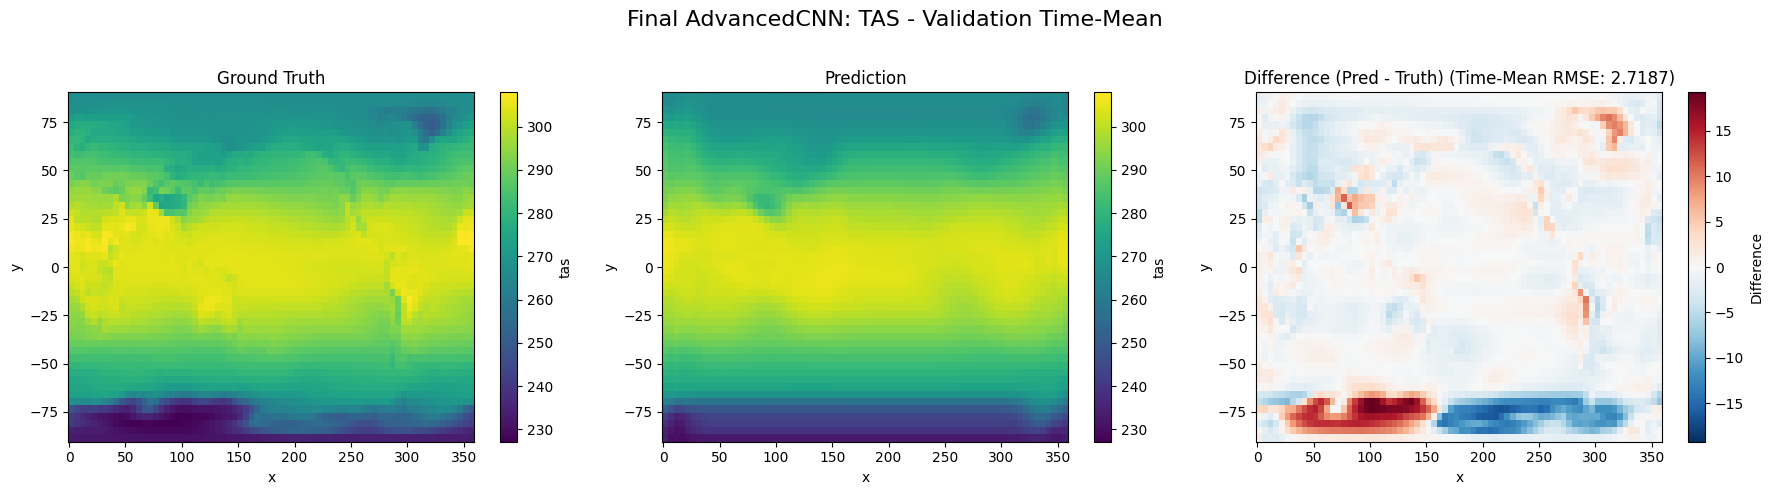

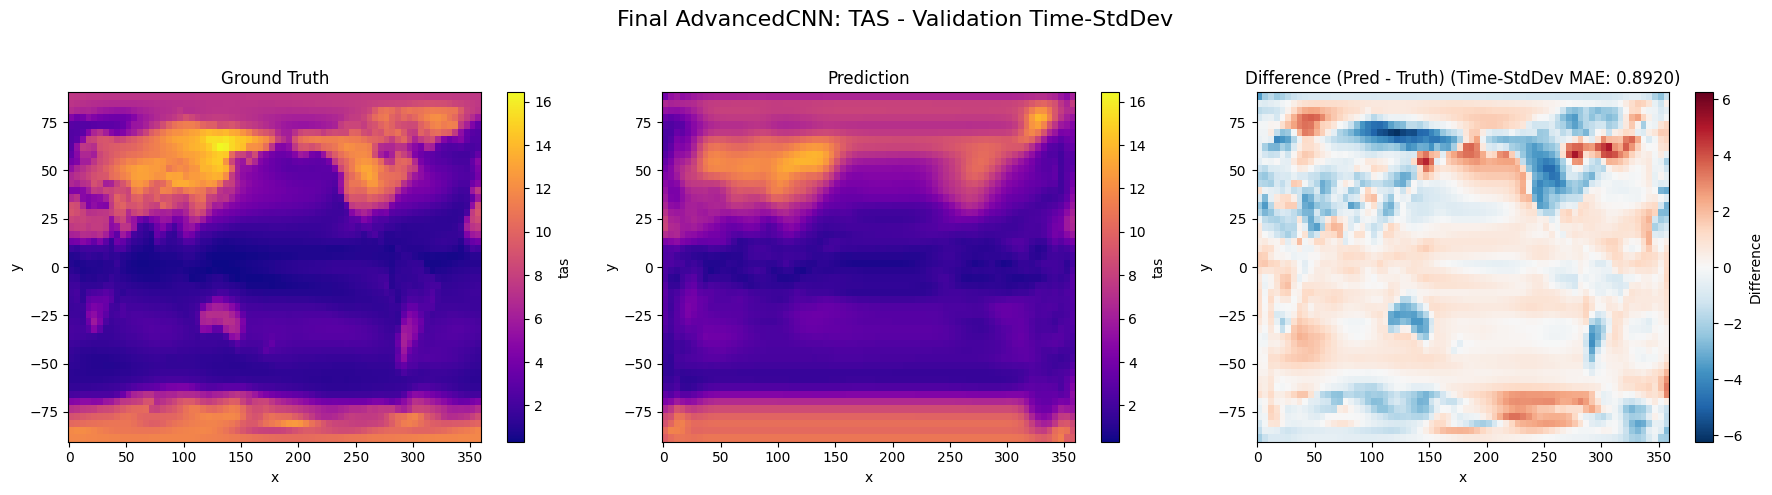

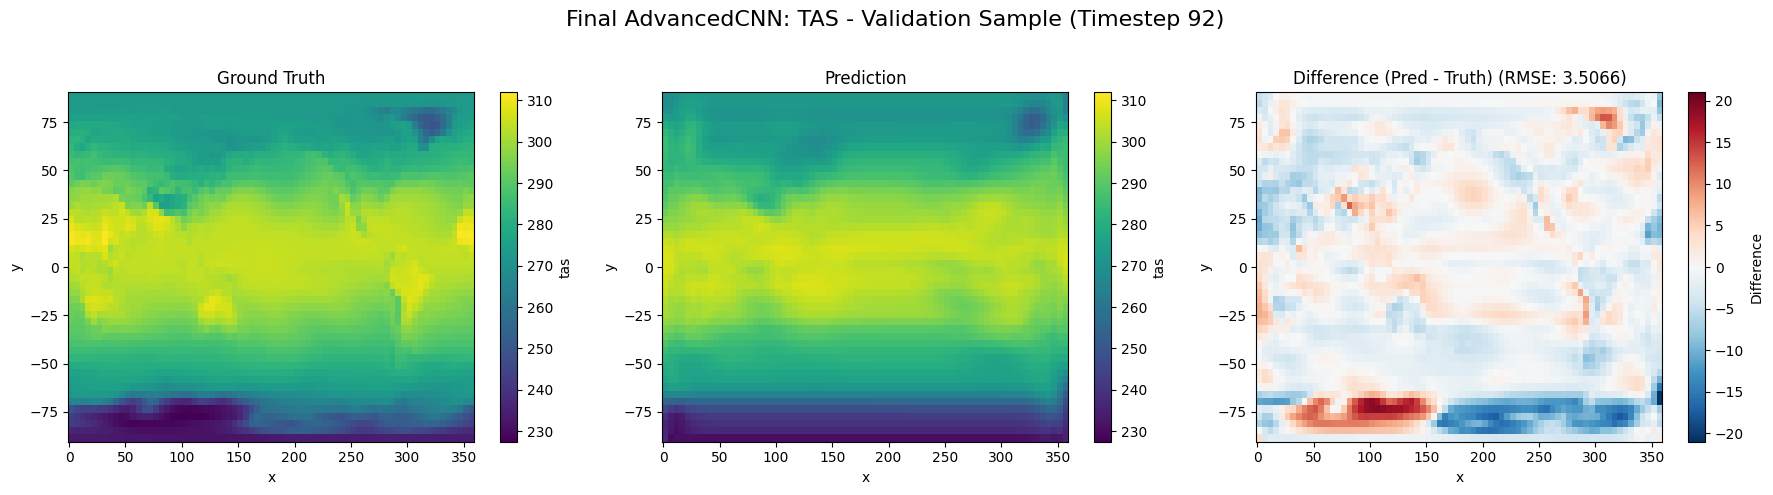

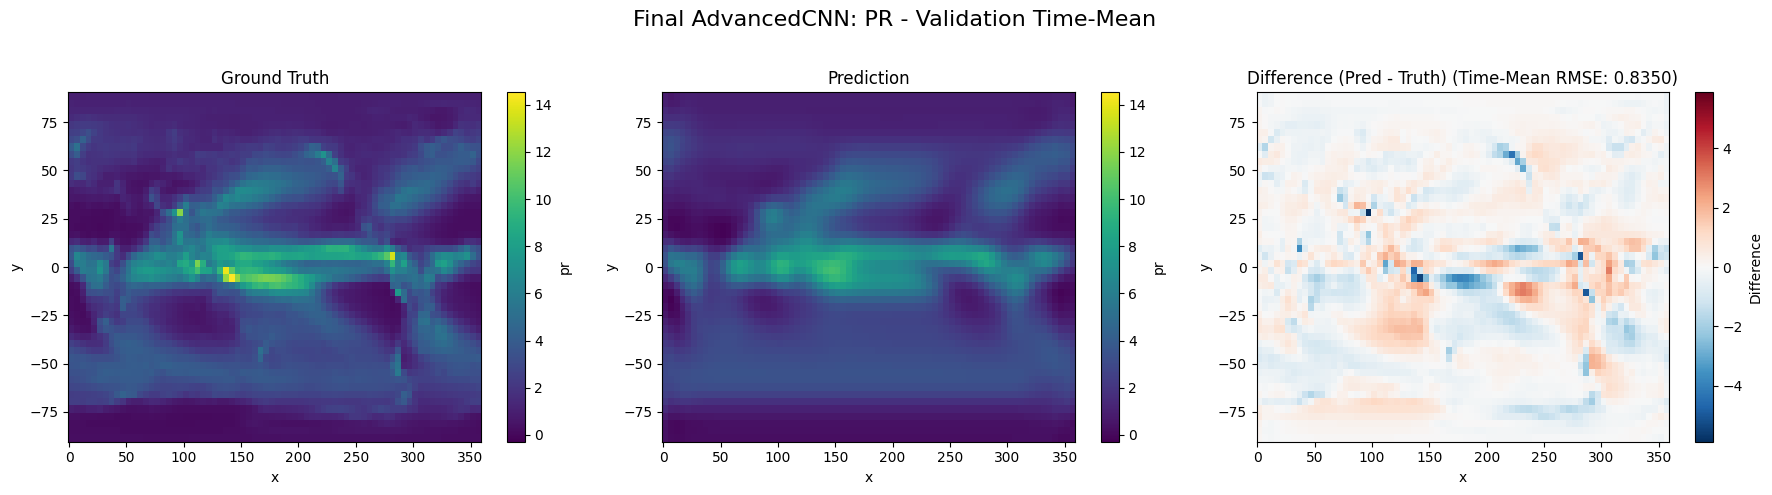

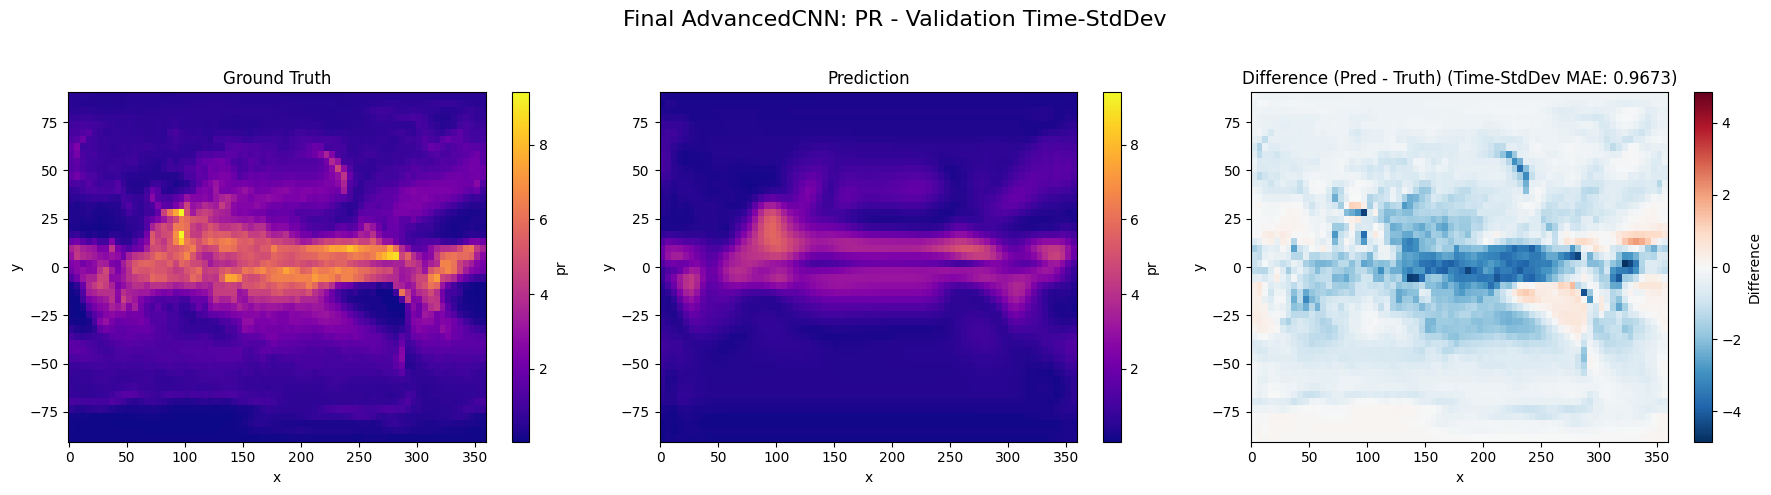

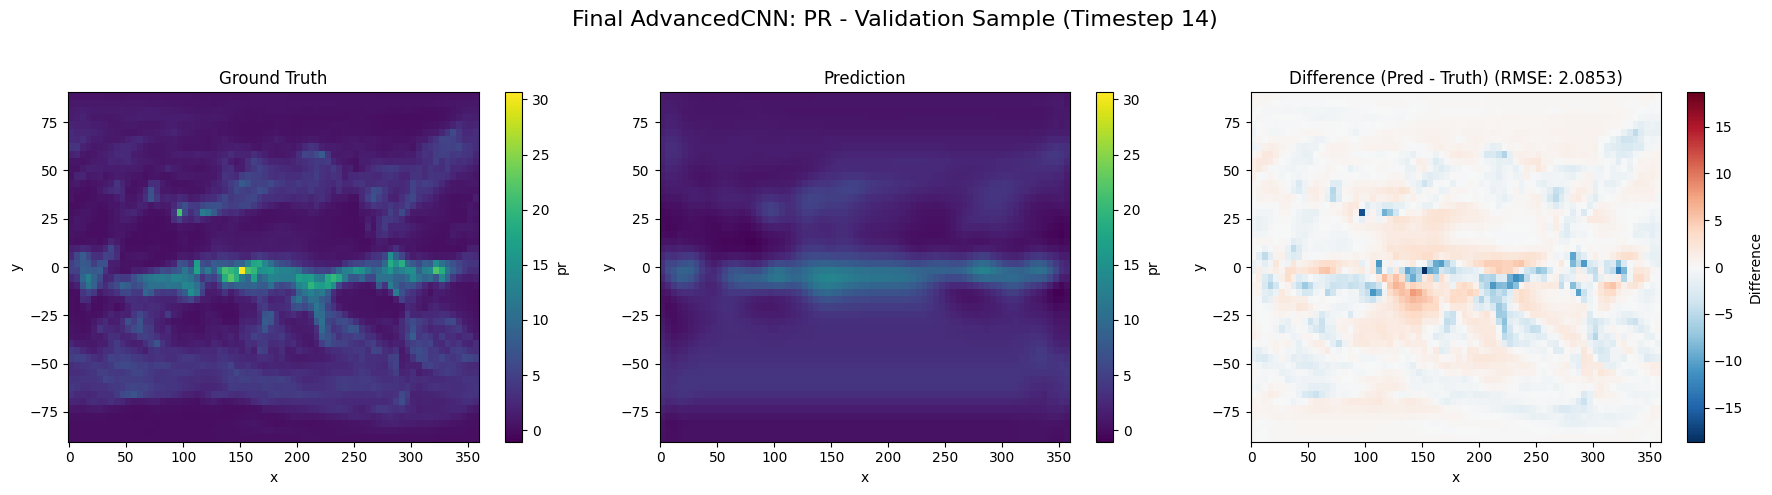

In [13]:
# Cell 13: AdvancedCNN - Final Visualization
# This cell loads the validation predictions saved during the FINAL AdvancedCNN training run and plots them.

print(f"\n--- Visualizing Validation Predictions for Final AdvancedCNN ---")
try:
    val_preds_loaded_final_adv_cnn = np.load("val_preds.npy") 
    val_trues_loaded_final_adv_cnn = np.load("val_trues.npy")

    if 'datamodule_final_adv_cnn' not in globals() or not hasattr(datamodule_final_adv_cnn, 'lat') or datamodule_final_adv_cnn.lat is None:
        print("datamodule_final_adv_cnn not fully set up for visualization. Setting it up...")
        datamodule_final_adv_cnn_viz = ClimateDataModule(**config["data"])
        datamodule_final_adv_cnn_viz.setup(stage="fit") 
        lat, lon = datamodule_final_adv_cnn_viz.get_coords()
        output_vars = config["data"]["output_vars"] 
        area_weights_vis = datamodule_final_adv_cnn_viz.get_lat_weights()
    else:
        lat, lon = datamodule_final_adv_cnn.get_coords()
        output_vars = config["data"]["output_vars"] 
        area_weights_vis = datamodule_final_adv_cnn.get_lat_weights() 
    
    time_val_coords = np.arange(val_preds_loaded_final_adv_cnn.shape[0])

    for i, var_name in enumerate(output_vars):
        pred_xr_final_adv_cnn = xr.DataArray(val_preds_loaded_final_adv_cnn[:, i], dims=["time", "y", "x"], 
                                   coords={"time": time_val_coords, "y": lat, "x": lon}, name=var_name)
        true_xr_final_adv_cnn = xr.DataArray(val_trues_loaded_final_adv_cnn[:, i], dims=["time", "y", "x"], 
                                   coords={"time": time_val_coords, "y": lat, "x": lon}, name=var_name)

        pred_mean_final_adv_cnn = pred_xr_final_adv_cnn.mean("time")
        true_mean_final_adv_cnn = true_xr_final_adv_cnn.mean("time")
        mean_rmse_var_final_adv_cnn = np.sqrt(((pred_mean_final_adv_cnn - true_mean_final_adv_cnn) ** 2).weighted(area_weights_vis).mean()).item()
        plot_comparison(true_mean_final_adv_cnn, pred_mean_final_adv_cnn, 
                        f"Final AdvancedCNN: {var_name.upper()} - Validation Time-Mean",
                        metric_val=mean_rmse_var_final_adv_cnn, metric_name="Time-Mean RMSE")

        pred_std_final_adv_cnn = pred_xr_final_adv_cnn.std("time")
        true_std_final_adv_cnn = true_xr_final_adv_cnn.std("time")
        std_mae_var_final_adv_cnn = np.abs(pred_std_final_adv_cnn - true_std_final_adv_cnn).weighted(area_weights_vis).mean().item()
        plot_comparison(true_std_final_adv_cnn, pred_std_final_adv_cnn, 
                        f"Final AdvancedCNN: {var_name.upper()} - Validation Time-StdDev", cmap="plasma",
                        metric_val=std_mae_var_final_adv_cnn, metric_name="Time-StdDev MAE")

        if len(time_val_coords) > 0:
            t_idx_random_final_adv_cnn = np.random.randint(0, len(time_val_coords))
            pred_sample_final_adv_cnn = pred_xr_final_adv_cnn.isel(time=t_idx_random_final_adv_cnn)
            true_sample_final_adv_cnn = true_xr_final_adv_cnn.isel(time=t_idx_random_final_adv_cnn)
            sample_rmse_var_final_adv_cnn = np.sqrt(((pred_sample_final_adv_cnn - true_sample_final_adv_cnn) ** 2).weighted(area_weights_vis).mean()).item()
            plot_comparison(true_sample_final_adv_cnn, pred_sample_final_adv_cnn, 
                            f"Final AdvancedCNN: {var_name.upper()} - Validation Sample (Timestep {t_idx_random_final_adv_cnn})",
                            metric_val=sample_rmse_var_final_adv_cnn, metric_name="RMSE")
        else:
            print(f"No time steps available in validation predictions for {var_name} to plot a random sample.")

except NameError as e:
    print(f"NameError during AdvancedCNN final visualization: {e}. Ensure 'best_run_adv_cnn' was defined and the final training cell (Cell 24) ran successfully.")
except FileNotFoundError:
    print("val_preds.npy or val_trues.npy not found for final AdvancedCNN run. "
          "Ensure that the final AdvancedCNN training and validation (Cell 24) has run successfully.")
except AttributeError as e:
    print(f"AttributeError during final AdvancedCNN visualization: {e}. Ensure datamodule_final_adv_cnn is correctly initialized.")
except Exception as e:
    print(f"An error occurred during final AdvancedCNN visualization: {e}")

